# SegFormer 脑肿瘤分割 - 训练Notebook

本notebook用于训练基于SegFormer的医学图像分割模型.

## 模型特点:
- SegFormer: 基于Transformer的2D语义分割模型
- 使用HuggingFace Transformers库
- 支持预训练的SegFormer模型

## 功能:
1. 从3D体积中提取2D切片
2. 加载和训练SegFormer模型
3. 模型评估和可视化
4. 与之前的模型进行对比


## 1. 安装依赖和挂载Google Drive


In [ ]:
# 挂载Google Drive
from google.colab import drive
import time

# 尝试挂载，如果失败则重试
max_retries = 3
retry_count = 0

while retry_count < max_retries:
    try:
        drive.mount('/content/drive', force_remount=False)
        print("Google Drive 挂载成功！")
        break
    except ValueError as e:
        retry_count += 1
        if retry_count < max_retries:
            print(f"挂载失败，{retry_count}/{max_retries} 次重试...")
            print("请确保：")
            print("1. 已点击授权链接并完成授权")
            print("2. 网络连接正常")
            print("3. 等待几秒后重试")
            time.sleep(5)
        else:
            print("挂载失败，请手动运行以下命令：")
            print("from google.colab import drive")
            print("drive.mount('/content/drive')")
            print("\n或者检查：")
            print("1. 是否已完成授权")
            print("2. 网络连接是否正常")
            print("3. 参考: https://research.google.com/colaboratory/faq.html#drive-timeout")
            raise


In [ ]:
# 安装必要的包
%pip install transformers -q
%pip install timm -q
%pip install nibabel -q
%pip install albumentations -q
%pip install einops -q
%pip install matplotlib -q


## 2. 导入库和配置参数


In [ ]:
# 导入必要的库
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Transformers导入
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers import SegformerImageProcessor

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


In [ ]:
# 数据路径配置
DRIVE_DATA_PATH = "/content/drive/MyDrive/data-brain-2024"
MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-segformer"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 训练参数
IMG_SIZE = 256  # 2D图像尺寸
BATCH_SIZE = 8  # 2D数据可以使用较大的batch size
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
VAL_INTERVAL = 1
NUM_CLASSES = 4  # 背景 + 3个肿瘤类别

# SegFormer模型选择: 'b0', 'b1', 'b2', 'b3', 'b4', 'b5'
SEGFORMER_MODEL = 'b0'  # 可以修改为其他版本 (b0最小最快, b5最大最准确)

# 切片提取参数
SLICE_START = 22
NUM_SLICES = 100

print(f"数据路径: {DRIVE_DATA_PATH}")
print(f"模型保存路径: {MODEL_SAVE_PATH}")
print(f"图像尺寸: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"SegFormer模型: {SEGFORMER_MODEL}")


## 3. 数据加载和预处理（提取2D切片）


In [ ]:
def get_patient_groups(data_path):
    """获取所有患者的数据分组"""
    all_files = glob.glob(os.path.join(data_path, "*.nii"))
    patient_groups = defaultdict(lambda: defaultdict(dict))

    for file_path in all_files:
        filename = os.path.basename(file_path)
        match = re.match(r'BraTS-GLI-(\d+)-(\d+)-(t1n|t2f|t2w|t1c|seg)\.nii', filename)
        if match:
            patient_id = match.group(1)
            sequence_id = match.group(2)
            modality = match.group(3)
            patient_groups[patient_id][sequence_id][modality] = file_path

    complete_patients = {}
    for patient_id, sequences in patient_groups.items():
        for seq_id, modalities in sequences.items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                if patient_id not in complete_patients:
                    complete_patients[patient_id] = {}
                complete_patients[patient_id][seq_id] = modalities

    return complete_patients

def load_nifti_volume(file_path):
    """加载NIfTI文件并返回numpy数组"""
    nii = nib.load(file_path)
    data = nii.get_fdata()
    return data

def extract_slices_from_volume(volume, start_idx=22, num_slices=100):
    """从3D体积中提取2D切片（沿z轴）"""
    depth = volume.shape[2]
    end_idx = min(start_idx + num_slices, depth)
    slices = volume[:, :, start_idx:end_idx]
    return slices

def normalize_slice(slice_data):
    """归一化单个切片"""
    slice_data = slice_data.astype(np.float32)
    max_val = np.max(slice_data)
    if max_val > 0:
        slice_data = slice_data / max_val
    return slice_data

def remap_labels(label_slice):
    """将标签值4映射到3"""
    label_slice = label_slice.astype(np.int64)
    label_slice[label_slice == 4] = 3
    return label_slice

# 获取所有患者数据
all_patient_groups = get_patient_groups(DRIVE_DATA_PATH)
patient_ids = list(all_patient_groups.keys())

print(f"找到 {len(patient_ids)} 个患者")
print(f"前5个患者ID: {patient_ids[:5]}")


In [ ]:
# 准备2D切片数据
def prepare_2d_slice_data(patient_groups, patient_ids):
    """从3D体积中提取2D切片，准备训练数据"""
    slice_data_list = []

    for patient_id in patient_ids:
        if patient_id not in patient_groups:
            continue

        for seq_id, modalities in patient_groups[patient_id].items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                # 加载3D体积
                t2f_volume = load_nifti_volume(modalities['t2f'])
                t1c_volume = load_nifti_volume(modalities['t1c'])
                seg_volume = load_nifti_volume(modalities['seg'])

                # 提取切片
                t2f_slices = extract_slices_from_volume(t2f_volume, SLICE_START, NUM_SLICES)
                t1c_slices = extract_slices_from_volume(t1c_volume, SLICE_START, NUM_SLICES)
                seg_slices = extract_slices_from_volume(seg_volume, SLICE_START, NUM_SLICES)

                # 为每个切片创建数据项
                num_slices = t2f_slices.shape[2]
                for slice_idx in range(num_slices):
                    slice_data = {
                        't2f_slice': t2f_slices[:, :, slice_idx],
                        't1c_slice': t1c_slices[:, :, slice_idx],
                        'label_slice': seg_slices[:, :, slice_idx],
                        'patient_id': patient_id,
                        'sequence_id': seq_id,
                        'slice_idx': slice_idx
                    }
                    slice_data_list.append(slice_data)

    return slice_data_list

# 准备所有切片数据
all_slice_data = prepare_2d_slice_data(all_patient_groups, patient_ids)
print(f"总共提取了 {len(all_slice_data)} 个2D切片")


In [ ]:
# 按患者ID划分数据（避免数据泄露）
unique_patient_ids = list(set([item['patient_id'] for item in all_slice_data]))
train_patients, temp_patients = train_test_split(
    unique_patient_ids, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# 根据患者ID划分切片数据
train_slice_data = [item for item in all_slice_data if item['patient_id'] in train_patients]
val_slice_data = [item for item in all_slice_data if item['patient_id'] in val_patients]
test_slice_data = [item for item in all_slice_data if item['patient_id'] in test_patients]

print(f"训练集: {len(train_slice_data)} 个切片 ({len(train_patients)} 个患者)")
print(f"验证集: {len(val_slice_data)} 个切片 ({len(val_patients)} 个患者)")
print(f"测试集: {len(test_slice_data)} 个切片 ({len(test_patients)} 个患者)")
print(f"\n训练患者: {train_patients}")
print(f"验证患者: {val_patients}")
print(f"测试患者: {test_patients}")


## 4. 创建Dataset类（使用Albumentations进行数据增强）


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BrainTumor2DDataset(Dataset):
    def __init__(self, slice_data_list, img_size=256, is_train=True):
        self.slice_data_list = slice_data_list
        self.img_size = img_size
        self.is_train = is_train

        # 数据增强（训练时）
        if is_train:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),
                ToTensorV2()
            ])
        else:
            # 验证/测试时只做resize和归一化
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.slice_data_list)

    def __getitem__(self, idx):
        item = self.slice_data_list[idx]

        # 获取切片
        t2f_slice = normalize_slice(item['t2f_slice'])
        t1c_slice = normalize_slice(item['t1c_slice'])
        label_slice = remap_labels(item['label_slice'])

        # 合并两个模态为2通道图像，然后转换为RGB格式（SegFormer需要3通道）
        # 方法：将2通道复制为3通道，或者使用灰度图
        image = np.stack([t2f_slice, t1c_slice], axis=0)  # (2, H, W)
        # 转换为RGB: 使用FLAIR作为R和G通道，T1CE作为B通道
        image_rgb = np.zeros((3, image.shape[1], image.shape[2]), dtype=np.float32)
        image_rgb[0] = t2f_slice  # R channel
        image_rgb[1] = (t2f_slice + t1c_slice) / 2  # G channel (平均)
        image_rgb[2] = t1c_slice  # B channel
        image_rgb = np.transpose(image_rgb, (1, 2, 0))  # (H, W, 3)

        # 应用变换
        transformed = self.transform(image=image_rgb)
        image = transformed['image']  # (3, H, W)

        # 处理标签
        label_transformed = self.label_transform(image=label_slice)
        label = label_transformed['image'].squeeze(0).long()  # (H, W)

        return {
            'pixel_values': image,  # SegFormer使用pixel_values
            'labels': label,
            'patient_id': item['patient_id'],
            'slice_idx': item['slice_idx']
        }

# 创建数据集
train_dataset = BrainTumor2DDataset(train_slice_data, img_size=IMG_SIZE, is_train=True)
val_dataset = BrainTumor2DDataset(val_slice_data, img_size=IMG_SIZE, is_train=False)
test_dataset = BrainTumor2DDataset(test_slice_data, img_size=IMG_SIZE, is_train=False)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 测试数据加载
sample = train_dataset[0]
print(f"\n样本形状:")
print(f"  图像: {sample['pixel_values'].shape}")
print(f"  标签: {sample['labels'].shape}")
print(f"  标签值范围: {sample['labels'].min().item()} - {sample['labels'].max().item()}")


## 5. 创建SegFormer模型


In [ ]:
# 创建SegFormer模型
# 使用正确的模型名称：从backbone模型创建，或使用可用的预训练模型
backbone_model_name = f"nvidia/mit-{SEGFORMER_MODEL}"  # 例如: nvidia/mit-b0

try:
    # 方法1: 尝试从backbone创建模型
    print(f"从backbone模型创建: {backbone_model_name}")
    config = SegformerConfig.from_pretrained(backbone_model_name)
    config.num_labels = NUM_CLASSES
    config.semantic_loss_ignore_index = 255
    model = SegformerForSemanticSegmentation(config)
    print(f"成功创建SegFormer-{SEGFORMER_MODEL}模型")
except Exception as e:
    print(f"方法1失败: {e}")
    try:
        # 方法2: 尝试使用Cityscapes预训练模型
        cityscapes_model = f"nvidia/segformer-b{SEGFORMER_MODEL[-1]}-finetuned-cityscapes-1024-1024"
        print(f"尝试加载Cityscapes预训练模型: {cityscapes_model}")
        model = SegformerForSemanticSegmentation.from_pretrained(
            cityscapes_model,
            num_labels=NUM_CLASSES,
            ignore_mismatched_sizes=True
        )
        print(f"成功加载预训练模型: {cityscapes_model}")
    except Exception as e2:
        print(f"方法2失败: {e2}")
        # 方法3: 使用默认配置创建
        print(f"使用默认配置创建SegFormer-{SEGFORMER_MODEL}")
        config = SegformerConfig()
        config.num_labels = NUM_CLASSES
        config.num_encoder_blocks = 4
        config.depths = [2, 2, 2, 2] if SEGFORMER_MODEL == 'b0' else [2, 2, 6, 2]
        config.hidden_sizes = [32, 64, 160, 256] if SEGFORMER_MODEL == 'b0' else [64, 128, 320, 512]
        model = SegformerForSemanticSegmentation(config)
        print("使用默认配置创建模型成功")

model = model.to(device)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型创建完成")
print(f"总参数数量: {total_params / 1e6:.2f}M")
print(f"可训练参数: {trainable_params / 1e6:.2f}M")

# 定义损失函数和优化器
# SegFormer使用CrossEntropyLoss，但我们可以添加Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        # pred: (B, C, H, W) - logits
        # target: (B, H, W) - class indices
        
        # SegFormer输出可能尺寸不同，需要上采样到标签尺寸
        if pred.shape[2:] != target.shape[1:]:
            pred = torch.nn.functional.interpolate(
                pred, 
                size=target.shape[1:], 
                mode='bilinear', 
                align_corners=False
            )
        
        pred = torch.softmax(pred, dim=1)

        # 转换为one-hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)

        # 计算Dice系数（跳过背景类）
        dice_scores = []
        for c in range(1, self.num_classes):
            pred_c = pred[:, c]
            target_c = target_one_hot[:, c]

            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)

        dice_loss = 1.0 - torch.stack(dice_scores).mean()
        return dice_loss

dice_loss = DiceLoss(num_classes=NUM_CLASSES)
ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

def combined_loss(pred, target):
    # 处理尺寸不匹配
    if pred.shape[2:] != target.shape[1:]:
        pred = torch.nn.functional.interpolate(
            pred, 
            size=target.shape[1:], 
            mode='bilinear', 
            align_corners=False
        )
    dice = dice_loss(pred, target)
    ce = ce_loss(pred, target)
    return 0.5 * dice + 0.5 * ce

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"\n损失函数: Dice Loss + CrossEntropy Loss")
print(f"优化器: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"学习率调度器: ReduceLROnPlateau")


## 6. 训练和验证函数


In [ ]:
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(loader, desc="训练"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        
        # SegFormer输出
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        
        # 也可以使用自定义损失
        # logits = outputs.logits
        # loss = loss_function(logits, labels)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    return epoch_loss

def calculate_dice_score(pred, target, num_classes=4, smooth=1e-6):
    """计算Dice系数"""
    # SegFormer输出可能尺寸不同，需要上采样到标签尺寸
    if pred.shape[2:] != target.shape[1:]:
        # 上采样预测结果到标签尺寸
        pred = torch.nn.functional.interpolate(
            pred, 
            size=target.shape[1:], 
            mode='bilinear', 
            align_corners=False
        )
    
    pred = torch.softmax(pred, dim=1)
    pred_classes = torch.argmax(pred, dim=1)

    dice_scores = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union > 0:
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def val_epoch(model, loader, loss_function, device):
    model.eval()
    val_loss = 0
    all_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="验证"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()

            # 计算Dice分数
            dice = calculate_dice_score(logits, labels, NUM_CLASSES)
            all_dice_scores.append(dice)

    val_loss /= len(loader)
    mean_dice = np.mean(all_dice_scores)

    return val_loss, mean_dice

print("训练和验证函数定义完成")


## 7. 开始训练


In [ ]:
# 训练历史
train_losses = []
val_losses = []
val_dice_scores = []

best_val_loss = float('inf')
best_dice_score = 0.0

# 检查是否有检查点
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"找到检查点: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_dice_scores = checkpoint.get('val_dice_scores', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_dice_score = checkpoint.get('best_dice_score', 0.0)
    print(f"从Epoch {start_epoch}继续训练")
else:
    print("未找到检查点，从头开始训练")

print(f"\n开始训练，共 {NUM_EPOCHS} 个epoch")
print("=" * 60)


In [ ]:
# 训练循环
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, combined_loss, device)
    train_losses.append(train_loss)

    # 验证
    if (epoch + 1) % VAL_INTERVAL == 0:
        val_loss, mean_dice = val_epoch(model, val_loader, combined_loss, device)
        val_losses.append(val_loss)
        val_dice_scores.append(mean_dice)

        print(f"\n验证结果:")
        print(f"  训练Loss: {train_loss:.4f}")
        print(f"  验证Loss: {val_loss:.4f}")
        print(f"  Dice系数: {mean_dice:.4f}")

        # 更新学习率
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  当前学习率: {current_lr:.6f}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'dice_score': mean_dice,
            }, best_model_path)
            print(f"  保存最佳模型 (Loss: {val_loss:.4f}, Dice: {mean_dice:.4f})")

        if mean_dice > best_dice_score:
            best_dice_score = mean_dice

    # 保存检查点
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_dice_scores': val_dice_scores,
        'best_val_loss': best_val_loss,
        'best_dice_score': best_dice_score,
    }
    torch.save(checkpoint, checkpoint_path)

print("\n" + "=" * 60)
print("训练完成！")
print(f"最佳验证Loss: {best_val_loss:.4f}")
print(f"最佳Dice系数: {best_dice_score:.4f}")


## 8. 可视化训练历史


In [ ]:
# 绘制训练历史
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Training Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

if len(val_dice_scores) > 0:
    axes[1].plot(val_dice_scores, label='Validation Dice Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, "training_history.png"), dpi=150, bbox_inches='tight')
plt.show()


## 9. 加载最佳模型并在测试集上评估


In [ ]:
# 加载最佳模型
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Dice: {checkpoint['dice_score']:.4f})")
else:
    print("未找到最佳模型，使用当前模型")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_dice = val_epoch(model, test_loader, combined_loss, device)

print(f"\n测试集结果:")
print(f"  Loss: {test_loss:.4f}")
print(f"  平均Dice系数: {test_dice:.4f}")

# 保存测试结果
test_results = {
    'test_loss': test_loss,
    'test_dice_mean': test_dice,
    'model_type': f'SegFormer-{SEGFORMER_MODEL}',
    'timestamp': datetime.now().isoformat(),
}

results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n测试结果已保存到: {results_path}")


## 10. 训练结果分析


In [ ]:
# 训练结果分析
print("=" * 80)
print("TRAINING RESULTS ANALYSIS REPORT")
print("=" * 80)

print("\n[1. Training Progress]")
print(f"   Completed Epochs: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   Completion: {len(train_losses)/NUM_EPOCHS*100:.1f}%")

print("\n[2. Loss Function Analysis]")
if len(train_losses) > 0:
    print(f"   Training Loss:")
    print(f"      - Initial: {train_losses[0]:.4f}")
    print(f"      - Final: {train_losses[-1]:.4f}")
    improvement = train_losses[0] - train_losses[-1]
    improvement_pct = (improvement / train_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

if len(val_losses) > 0:
    print(f"\n   Validation Loss:")
    print(f"      - Initial: {val_losses[0]:.4f}")
    print(f"      - Final: {val_losses[-1]:.4f}")
    print(f"      - Best: {best_val_loss:.4f}")

print("\n[3. Dice Coefficient Analysis]")
if len(val_dice_scores) > 0:
    print(f"   Validation Dice Score:")
    print(f"      - Initial: {val_dice_scores[0]:.4f}")
    print(f"      - Final: {val_dice_scores[-1]:.4f}")
    print(f"      - Best: {best_dice_score:.4f}")
    print(f"      - Average: {np.mean(val_dice_scores):.4f}")

print("\n[4. Test Set Performance]")
if 'test_results' in locals():
    print(f"   Test Loss: {test_results['test_loss']:.4f}")
    print(f"   Test Dice Score: {test_results['test_dice_mean']:.4f}")

print("\n[5. Model Configuration]")
print(f"   Model Type: SegFormer-{SEGFORMER_MODEL}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


# HuggingFace 医学图像分割 - 训练Notebook

本notebook使用HuggingFace提供的预训练医学图像分割模型进行fine-tune训练.

## 功能：
1. 从3D体积中提取2D切片
2. 加载HuggingFace预训练模型（UNet/ResNet-UNet等）
3. Fine-tune训练
4. 模型评估和可视化


## 1. 安装依赖和挂载Google Drive


In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 安装必要的包
%pip install transformers -q
%pip install timm -q  # 用于预训练模型
%pip install segmentation-models-pytorch -q  # 医学图像分割模型库
%pip install nibabel -q  # NIfTI文件读取
%pip install albumentations -q  # 数据增强
%pip install einops -q  # 张量操作


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
# 导入必要的库
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


使用设备: cpu


## 2. 配置参数


In [ ]:
# 数据路径
DRIVE_DATA_PATH = "/content/drive/MyDrive/data-brain-2024"
MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 训练参数
IMG_SIZE = 256  # 2D图像尺寸（可以比3D UNet更大）
BATCH_SIZE = 8  # 2D数据可以使用更大的batch size
LEARNING_RATE = 1e-4  # 使用较小的学习率进行fine-tune
NUM_EPOCHS = 50
VAL_INTERVAL = 1
NUM_CLASSES = 4  # 背景 + 3个肿瘤类别

# 切片提取参数
SLICE_START = 22  # 从第22层开始提取
NUM_SLICES = 100  # 每个体积提取100个切片

# 模型选择
# 选项: 'unet', 'fpn', 'linknet'
MODEL_TYPE = 'unet'  # 可以修改为其他模型

# 预训练模型名称（segmentation_models_pytorch）
PRETRAINED_ENCODER = 'resnet34'  # 可选: resnet34, resnet50, efficientnet-b0等

print(f"图像尺寸: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"模型类型: {MODEL_TYPE}")
print(f"预训练编码器: {PRETRAINED_ENCODER}")


图像尺寸: 256x256
Batch Size: 8
学习率: 0.0001
模型类型: unet
预训练编码器: resnet34


## 3. 数据加载和预处理（提取2D切片）


In [ ]:
def get_patient_groups(data_path):
    """获取所有患者的数据分组"""
    all_files = glob.glob(os.path.join(data_path, "*.nii"))
    patient_groups = defaultdict(lambda: defaultdict(dict))

    for file_path in all_files:
        filename = os.path.basename(file_path)
        match = re.match(r'BraTS-GLI-(\d+)-(\d+)-(t1n|t2f|t2w|t1c|seg)\.nii', filename)
        if match:
            patient_id = match.group(1)
            sequence_id = match.group(2)
            modality = match.group(3)
            patient_groups[patient_id][sequence_id][modality] = file_path

    complete_patients = {}
    for patient_id, sequences in patient_groups.items():
        for seq_id, modalities in sequences.items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                if patient_id not in complete_patients:
                    complete_patients[patient_id] = {}
                complete_patients[patient_id][seq_id] = modalities

    return complete_patients

def load_nifti_volume(file_path):
    """加载NIfTI文件并返回numpy数组"""
    nii = nib.load(file_path)
    data = nii.get_fdata()
    return data

def extract_slices_from_volume(volume, start_idx=22, num_slices=100):
    """从3D体积中提取2D切片（沿z轴）"""
    depth = volume.shape[2]
    end_idx = min(start_idx + num_slices, depth)
    slices = volume[:, :, start_idx:end_idx]
    return slices

def normalize_slice(slice_data):
    """归一化单个切片"""
    slice_data = slice_data.astype(np.float32)
    max_val = np.max(slice_data)
    if max_val > 0:
        slice_data = slice_data / max_val
    return slice_data

def remap_labels(label_slice):
    """将标签值4映射到3"""
    label_slice = label_slice.astype(np.int64)
    label_slice[label_slice == 4] = 3
    return label_slice

# 获取所有患者数据
all_patient_groups = get_patient_groups(DRIVE_DATA_PATH)
patient_ids = list(all_patient_groups.keys())

print(f"找到 {len(patient_ids)} 个患者")
print(f"前5个患者ID: {patient_ids[:5]}")


找到 14 个患者
前5个患者ID: ['00009', '00020', '00027', '00033', '00046']


In [ ]:
# 准备2D切片数据
def prepare_2d_slice_data(patient_groups, patient_ids):
    """从3D体积中提取2D切片，准备训练数据"""
    slice_data_list = []

    for patient_id in patient_ids:
        if patient_id not in patient_groups:
            continue

        for seq_id, modalities in patient_groups[patient_id].items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                # 加载3D体积
                t2f_volume = load_nifti_volume(modalities['t2f'])
                t1c_volume = load_nifti_volume(modalities['t1c'])
                seg_volume = load_nifti_volume(modalities['seg'])

                # 提取切片
                t2f_slices = extract_slices_from_volume(t2f_volume, SLICE_START, NUM_SLICES)
                t1c_slices = extract_slices_from_volume(t1c_volume, SLICE_START, NUM_SLICES)
                seg_slices = extract_slices_from_volume(seg_volume, SLICE_START, NUM_SLICES)

                # 为每个切片创建数据项
                num_slices = t2f_slices.shape[2]
                for slice_idx in range(num_slices):
                    slice_data = {
                        't2f_slice': t2f_slices[:, :, slice_idx],
                        't1c_slice': t1c_slices[:, :, slice_idx],
                        'label_slice': seg_slices[:, :, slice_idx],
                        'patient_id': patient_id,
                        'sequence_id': seq_id,
                        'slice_idx': slice_idx
                    }
                    slice_data_list.append(slice_data)

    return slice_data_list

# 准备所有切片数据
all_slice_data = prepare_2d_slice_data(all_patient_groups, patient_ids)
print(f"总共提取了 {len(all_slice_data)} 个2D切片")


总共提取了 2700 个2D切片


In [ ]:
# 按患者ID划分数据（避免数据泄露）
unique_patient_ids = list(set([item['patient_id'] for item in all_slice_data]))
train_patients, temp_patients = train_test_split(
    unique_patient_ids, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# 根据患者ID划分切片数据
train_slice_data = [item for item in all_slice_data if item['patient_id'] in train_patients]
val_slice_data = [item for item in all_slice_data if item['patient_id'] in val_patients]
test_slice_data = [item for item in all_slice_data if item['patient_id'] in test_patients]

print(f"训练集: {len(train_slice_data)} 个切片 ({len(train_patients)} 个患者)")
print(f"验证集: {len(val_slice_data)} 个切片 ({len(val_patients)} 个患者)")
print(f"测试集: {len(test_slice_data)} 个切片 ({len(test_patients)} 个患者)")
print(f"\n训练患者: {train_patients}")
print(f"验证患者: {val_patients}")
print(f"测试患者: {test_patients}")


训练集: 1700 个切片 (9 个患者)
验证集: 400 个切片 (2 个患者)
测试集: 600 个切片 (3 个患者)

训练患者: ['00080', '00463', '00033', '00027', '00096', '00046', '00085', '00063', '00472']
验证患者: ['00009', '00020']
测试患者: ['00078', '00060', '00469']


## 4. 创建Dataset类（使用Albumentations进行数据增强）


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BrainTumor2DDataset(Dataset):
    def __init__(self, slice_data_list, img_size=256, is_train=True):
        self.slice_data_list = slice_data_list
        self.img_size = img_size
        self.is_train = is_train

        # 数据增强（训练时）
        if is_train:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),  # 归一化到[-1, 1]
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),  # 最近邻插值
                ToTensorV2()
            ])
        else:
            # 验证/测试时只做resize和归一化
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.slice_data_list)

    def __getitem__(self, idx):
        item = self.slice_data_list[idx]

        # 获取切片
        t2f_slice = normalize_slice(item['t2f_slice'])
        t1c_slice = normalize_slice(item['t1c_slice'])
        label_slice = remap_labels(item['label_slice'])

        # 合并两个模态为2通道图像
        image = np.stack([t2f_slice, t1c_slice], axis=0)  # (2, H, W)
        image = np.transpose(image, (1, 2, 0))  # (H, W, 2)

        # 应用变换
        transformed = self.transform(image=image)
        image = transformed['image']  # (2, H, W)

        # 处理标签
        label_transformed = self.label_transform(image=label_slice)
        label = label_transformed['image'].squeeze(0).long()  # (H, W)

        return {
            'image': image,  # (2, H, W)
            'label': label,  # (H, W)
            'patient_id': item['patient_id'],
            'slice_idx': item['slice_idx']
        }

# 创建数据集
train_dataset = BrainTumor2DDataset(train_slice_data, img_size=IMG_SIZE, is_train=True)
val_dataset = BrainTumor2DDataset(val_slice_data, img_size=IMG_SIZE, is_train=False)
test_dataset = BrainTumor2DDataset(test_slice_data, img_size=IMG_SIZE, is_train=False)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 测试数据加载
sample = train_dataset[0]
print(f"\n样本形状:")
print(f"  图像: {sample['image'].shape}")
print(f"  标签: {sample['label'].shape}")
print(f"  标签值范围: {sample['label'].min().item()} - {sample['label'].max().item()}")


训练集大小: 1700
验证集大小: 400
测试集大小: 600

样本形状:
  图像: torch.Size([2, 256, 256])
  标签: torch.Size([256, 256])
  标签值范围: 0 - 0


In [ ]:
import segmentation_models_pytorch as smp

# 创建UNet模型（使用预训练编码器）
def create_model(model_type='unet', encoder_name='resnet34', num_classes=4, in_channels=2):
    """
    创建分割模型

    参数:
        model_type: 'unet', 'fpn', 'linknet', 'pspnet'
        encoder_name: 预训练编码器名称
        num_classes: 输出类别数
        in_channels: 输入通道数（2通道：FLAIR + T1CE）
    """
    if model_type == 'unet':
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet',  # 使用ImageNet预训练权重
            in_channels=in_channels,
            classes=num_classes,
            activation=None,  # 使用logits，在loss中处理softmax
        )
    elif model_type == 'fpn':
        model = smp.FPN(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=num_classes,
            activation=None,
        )
    elif model_type == 'linknet':
        model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=num_classes,
            activation=None,
        )
    else:
        raise ValueError(f"不支持的模型类型: {model_type}")

    return model

# 创建模型
model = create_model(
    model_type=MODEL_TYPE,
    encoder_name=PRETRAINED_ENCODER,
    num_classes=NUM_CLASSES,
    in_channels=2  # FLAIR + T1CE
)

model = model.to(device)

# 打印模型信息
print(f"模型类型: {MODEL_TYPE}")
print(f"编码器: {PRETRAINED_ENCODER}")
print(f"输入通道: 2 (FLAIR + T1CE)")
print(f"输出类别: {NUM_CLASSES}")

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数量: {total_params / 1e6:.2f}M")
print(f"可训练参数量: {trainable_params / 1e6:.2f}M")

# 测试前向传播
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    test_input = sample_batch['image'].to(device)
    test_output = model(test_input)
    print(f"\n测试输出形状: {test_output.shape}")
    print(f"期望输出形状: (batch_size, {NUM_CLASSES}, {IMG_SIZE}, {IMG_SIZE})")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

模型类型: unet
编码器: resnet34
输入通道: 2 (FLAIR + T1CE)
输出类别: 4

总参数量: 24.43M
可训练参数量: 24.43M


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



测试输出形状: torch.Size([8, 4, 256, 256])
期望输出形状: (batch_size, 4, 256, 256)


In [ ]:
# 损失函数：Dice Loss + CrossEntropy Loss
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        # pred: (B, C, H, W) - logits
        # target: (B, H, W) - class indices
        pred = torch.softmax(pred, dim=1)

        # 转换为one-hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)

        # 计算Dice系数（跳过背景类）
        dice_scores = []
        for c in range(1, self.num_classes):  # 跳过背景
            pred_c = pred[:, c]
            target_c = target_one_hot[:, c]

            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)

        dice_loss = 1.0 - torch.stack(dice_scores).mean()
        return dice_loss

# 组合损失函数
dice_loss = DiceLoss(num_classes=NUM_CLASSES)
ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

def combined_loss(pred, target):
    dice = dice_loss(pred, target)
    ce = ce_loss(pred, target)
    return 0.5 * dice + 0.5 * ce

# 优化器和学习率调度器
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"损失函数: Dice Loss + CrossEntropy Loss")
print(f"优化器: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"学习率调度器: ReduceLROnPlateau")


损失函数: Dice Loss + CrossEntropy Loss
优化器: AdamW (lr=0.0001, weight_decay=1e-4)
学习率调度器: ReduceLROnPlateau


## 7. 训练和验证函数


In [ ]:
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(loader, desc="训练"):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    return epoch_loss

def calculate_dice_score(pred, target, num_classes=4, smooth=1e-6):
    """计算Dice系数"""
    pred = torch.softmax(pred, dim=1)
    pred_classes = torch.argmax(pred, dim=1)

    dice_scores = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union > 0:
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def val_epoch(model, loader, loss_function, device):
    model.eval()
    val_loss = 0
    all_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="验证"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # 计算Dice分数
            dice = calculate_dice_score(outputs, labels, NUM_CLASSES)
            all_dice_scores.append(dice)

    val_loss /= len(loader)
    mean_dice = np.mean(all_dice_scores)

    return val_loss, mean_dice


## 8. 训练循环


In [ ]:
# 训练历史
train_losses = []
val_losses = []
val_dice_scores = []

best_val_loss = float('inf')
best_dice_score = 0.0

# 检查是否有检查点
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"找到检查点: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_dice_scores = checkpoint.get('val_dice_scores', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_dice_score = checkpoint.get('best_dice_score', 0.0)
    print(f"从Epoch {start_epoch}继续训练")
else:
    print("未找到检查点，从头开始训练")

# 训练循环
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, combined_loss, device)
    train_losses.append(train_loss)

    # 验证
    if (epoch + 1) % VAL_INTERVAL == 0:
        val_loss, mean_dice = val_epoch(model, val_loader, combined_loss, device)
        val_losses.append(val_loss)
        val_dice_scores.append(mean_dice)

        print(f"\n验证结果:")
        print(f"  训练Loss: {train_loss:.4f}")
        print(f"  验证Loss: {val_loss:.4f}")
        print(f"  Dice系数: {mean_dice:.4f}")

        # 更新学习率
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  当前学习率: {current_lr:.6f}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'dice_score': mean_dice,
            }, best_model_path)
            print(f"  ✅ 保存最佳模型 (Loss: {val_loss:.4f}, Dice: {mean_dice:.4f})")

        if mean_dice > best_dice_score:
            best_dice_score = mean_dice

        # 保存检查点
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_dice_scores': val_dice_scores,
            'best_val_loss': best_val_loss,
            'best_dice_score': best_dice_score,
        }
        torch.save(checkpoint, checkpoint_path)

print("\n" + "=" * 60)
print("训练完成！")
print(f"最佳验证Loss: {best_val_loss:.4f}")
print(f"最佳Dice系数: {best_dice_score:.4f}")


未找到检查点，从头开始训练

Epoch 1/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:21<00:00,  2.13s/it]



验证结果:
  训练Loss: 0.7976
  验证Loss: 0.6158
  Dice系数: 0.0195
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.6158, Dice: 0.0195)

Epoch 2/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.5576
  验证Loss: 0.5486
  Dice系数: 0.0281
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5486, Dice: 0.0281)

Epoch 3/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.4964
  验证Loss: 0.5238
  Dice系数: 0.0535
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5238, Dice: 0.0535)

Epoch 4/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:22<00:00,  2.17s/it]



验证结果:
  训练Loss: 0.4597
  验证Loss: 0.5153
  Dice系数: 0.0443
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5153, Dice: 0.0443)

Epoch 5/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:17<00:00,  2.04s/it]



验证结果:
  训练Loss: 0.4364
  验证Loss: 0.5308
  Dice系数: 0.0000
  当前学习率: 0.000100

Epoch 6/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.03s/it]



验证结果:
  训练Loss: 0.4082
  验证Loss: 0.5147
  Dice系数: 0.0269
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5147, Dice: 0.0269)

Epoch 7/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:19<00:00,  2.10s/it]



验证结果:
  训练Loss: 0.3904
  验证Loss: 0.5260
  Dice系数: 0.0094
  当前学习率: 0.000100

Epoch 8/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.98s/it]



验证结果:
  训练Loss: 0.3815
  验证Loss: 0.5311
  Dice系数: 0.0002
  当前学习率: 0.000100

Epoch 9/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:11<00:00,  1.89s/it]



验证结果:
  训练Loss: 0.3533
  验证Loss: 0.5016
  Dice系数: 0.0620
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5016, Dice: 0.0620)

Epoch 10/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.98s/it]



验证结果:
  训练Loss: 0.3425
  验证Loss: 0.5305
  Dice系数: 0.0220
  当前学习率: 0.000100

Epoch 11/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.3345
  验证Loss: 0.5145
  Dice系数: 0.0424
  当前学习率: 0.000100

Epoch 12/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:12<00:00,  1.90s/it]



验证结果:
  训练Loss: 0.3241
  验证Loss: 0.5098
  Dice系数: 0.0605
  当前学习率: 0.000100

Epoch 13/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.99s/it]



验证结果:
  训练Loss: 0.3042
  验证Loss: 0.5386
  Dice系数: 0.0272
  当前学习率: 0.000100

Epoch 14/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.96s/it]



验证结果:
  训练Loss: 0.2886
  验证Loss: 0.5323
  Dice系数: 0.0227
  当前学习率: 0.000100

Epoch 15/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:12<00:00,  1.92s/it]



验证结果:
  训练Loss: 0.2888
  验证Loss: 0.5363
  Dice系数: 0.0100
  当前学习率: 0.000050

Epoch 16/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:21<00:00,  2.13s/it]



验证结果:
  训练Loss: 0.2710
  验证Loss: 0.5287
  Dice系数: 0.0190
  当前学习率: 0.000050

Epoch 17/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:13<00:00,  1.92s/it]



验证结果:
  训练Loss: 0.2546
  验证Loss: 0.5213
  Dice系数: 0.0315
  当前学习率: 0.000050

Epoch 18/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:19<00:00,  2.09s/it]



验证结果:
  训练Loss: 0.2476
  验证Loss: 0.5389
  Dice系数: 0.0001
  当前学习率: 0.000050

Epoch 19/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:26<00:00,  2.28s/it]



验证结果:
  训练Loss: 0.2509
  验证Loss: 0.5346
  Dice系数: 0.0140
  当前学习率: 0.000050

Epoch 20/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2421
  验证Loss: 0.5304
  Dice系数: 0.0173
  当前学习率: 0.000050

Epoch 21/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.2448
  验证Loss: 0.5405
  Dice系数: 0.0119
  当前学习率: 0.000025

Epoch 22/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:13<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2381
  验证Loss: 0.5225
  Dice系数: 0.0410
  当前学习率: 0.000025

Epoch 23/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.2293
  验证Loss: 0.5227
  Dice系数: 0.0409
  当前学习率: 0.000025

Epoch 24/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.2328
  验证Loss: 0.5267
  Dice系数: 0.0260
  当前学习率: 0.000025

Epoch 25/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.2219
  验证Loss: 0.5254
  Dice系数: 0.0344
  当前学习率: 0.000025

Epoch 26/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:22<00:00,  2.18s/it]



验证结果:
  训练Loss: 0.2195
  验证Loss: 0.5281
  Dice系数: 0.0325
  当前学习率: 0.000025

Epoch 27/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:17<00:00,  2.05s/it]



验证结果:
  训练Loss: 0.2246
  验证Loss: 0.5310
  Dice系数: 0.0251
  当前学习率: 0.000013

Epoch 28/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2175
  验证Loss: 0.5297
  Dice系数: 0.0265
  当前学习率: 0.000013

Epoch 29/50
------------------------------------------------------------


训练:  25%|██▌       | 57/225 [06:18<19:04,  6.81s/it]

In [ ]:
# ============================================
# 🔍 检查之前的训练进度（重要！）
# 运行此代码块检查是否有保存的检查点
# ============================================

# 首先确保路径已设置（如果还没运行前面的代码）
if 'MODEL_SAVE_PATH' not in globals():
    MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"

checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")

print("=" * 60)
print("🔍 检查训练进度...")
print("=" * 60)

# 检查检查点文件
if os.path.exists(checkpoint_path):
    print(f"\n✅ 找到检查点文件！")
    print(f"   路径: {checkpoint_path}")

    try:
        # 加载检查点信息（不加载模型，只查看信息）
        checkpoint_info = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

        print(f"\n📊 检查点详细信息:")
        print(f"   ✅ 已训练Epoch: {checkpoint_info['epoch'] + 1}")
        if 'NUM_EPOCHS' in globals():
            print(f"   📈 总Epoch数: {NUM_EPOCHS}")
            remaining = NUM_EPOCHS - (checkpoint_info['epoch'] + 1)
            print(f"   ⏳ 剩余Epoch: {remaining}")

        print(f"   🏆 最佳验证Loss: {checkpoint_info.get('best_val_loss', 'N/A'):.4f}")
        print(f"   🎯 最佳Dice系数: {checkpoint_info.get('best_dice_score', 0.0):.4f}")

        train_losses = checkpoint_info.get('train_losses', [])
        val_losses = checkpoint_info.get('val_losses', [])
        print(f"   📉 训练历史: {len(train_losses)} 个训练loss, {len(val_losses)} 个验证loss")

        if train_losses:
            print(f"   📊 最新训练Loss: {train_losses[-1]:.4f}")
        if val_losses:
            print(f"   📊 最新验证Loss: {val_losses[-1]:.4f}")

        print(f"\n✅ 可以恢复训练！")
        print(f"   🔄 将从 Epoch {checkpoint_info['epoch'] + 2} 继续训练")
        print(f"   💡 直接运行训练循环代码块（Cell 20）即可自动恢复")

    except Exception as e:
        print(f"\n❌ 检查点文件损坏或无法读取: {e}")
        print("   可能需要重新训练")
else:
    print(f"\n⚠️ 未找到检查点文件")
    print(f"   路径: {checkpoint_path}")
    print(f"\n可能的原因:")
    print("   1. 训练还没有运行过")
    print("   2. 检查点文件没有保存到 Google Drive")
    print("   3. 文件路径不正确")
    print(f"\n💡 建议:")
    print("   - 检查 Google Drive 中是否存在该文件")
    print("   - 如果确实没有，需要从头开始训练")

# 检查最佳模型文件
print(f"\n" + "-" * 60)
if os.path.exists(best_model_path):
    print(f"✅ 找到最佳模型文件: best_model.pth")
    try:
        best_model_info = torch.load(best_model_path, map_location='cpu', weights_only=False)
        print(f"   - Epoch: {best_model_info.get('epoch', 'N/A')}")
        print(f"   - 验证Loss: {best_model_info.get('val_loss', 'N/A'):.4f}")
        print(f"   - Dice系数: {best_model_info.get('dice_score', 'N/A'):.4f}")
    except:
        print("   - 文件存在但无法读取详细信息")
else:
    print(f"⚠️ 未找到最佳模型文件")

print("=" * 60)


🔍 检查训练进度...

✅ 找到检查点文件！
   路径: /content/drive/MyDrive/brain-tumor-models-hf/checkpoint_latest.pth

📊 检查点详细信息:
   ✅ 已训练Epoch: 28
   📈 总Epoch数: 50
   ⏳ 剩余Epoch: 22
   🏆 最佳验证Loss: 0.5016
   🎯 最佳Dice系数: 0.0620
   📉 训练历史: 28 个训练loss, 28 个验证loss
   📊 最新训练Loss: 0.2175
   📊 最新验证Loss: 0.5297

✅ 可以恢复训练！
   🔄 将从 Epoch 29 继续训练
   💡 直接运行训练循环代码块（Cell 20）即可自动恢复

------------------------------------------------------------
✅ 找到最佳模型文件: best_model.pth
   - Epoch: 8
   - 验证Loss: 0.5016
   - Dice系数: 0.0620


In [ ]:
# ============================================
# 快速检查：查看保存的模型和检查点
# ============================================

import os
from pathlib import Path

print("📁 检查保存的模型文件：")
print(f"   保存路径: {MODEL_SAVE_PATH}\n")

# 检查目录是否存在
if os.path.exists(MODEL_SAVE_PATH):
    files = os.listdir(MODEL_SAVE_PATH)
    if files:
        print("✅ 找到以下文件：")
        for file in sorted(files):
            file_path = os.path.join(MODEL_SAVE_PATH, file)
            if os.path.isfile(file_path):
                size_mb = os.path.getsize(file_path) / (1024 * 1024)
                print(f"   - {file} ({size_mb:.2f} MB)")
    else:
        print("⚠️ 目录为空，还没有保存任何文件")
else:
    print(f"❌ 目录不存在: {MODEL_SAVE_PATH}")

# 特别检查检查点文件
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
if os.path.exists(checkpoint_path):
    print(f"\n✅ 检查点文件存在: checkpoint_latest.pth")
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    print(f"   - 已训练Epoch: {checkpoint['epoch'] + 1}")
    print(f"   - 可以从此处恢复训练")
else:
    print(f"\n⚠️ 检查点文件不存在，将从头开始训练")


📁 检查保存的模型文件：
   保存路径: /content/drive/MyDrive/brain-tumor-models-hf

✅ 找到以下文件：
   - best_model.pth (279.89 MB)
   - checkpoint_latest.pth (279.90 MB)

✅ 检查点文件存在: checkpoint_latest.pth
   - 已训练Epoch: 28
   - 可以从此处恢复训练


In [ ]:
# 加载最佳模型
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Dice: {checkpoint['dice_score']:.4f})")
else:
    print("未找到最佳模型，使用当前模型")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_dice = val_epoch(model, test_loader, combined_loss, device)

print(f"\n测试集结果:")
print(f"  Loss: {test_loss:.4f}")
print(f"  平均Dice系数: {test_dice:.4f}")

# 保存测试结果
test_results = {
    'test_loss': test_loss,
    'test_dice_mean': test_dice,
    'model_type': MODEL_TYPE,
    'encoder_name': PRETRAINED_ENCODER,
    'timestamp': datetime.now().isoformat(),
}

results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n测试结果已保存到: {results_path}")


加载最佳模型 (Epoch 8, Dice: 0.0620)

在测试集上评估...


验证: 100%|██████████| 75/75 [04:18<00:00,  3.45s/it]


测试集结果:
  Loss: 0.4760
  平均Dice系数: 0.2840

测试结果已保存到: /content/drive/MyDrive/brain-tumor-models-hf/test_results.json


## 10. 可视化训练历史和预测结果


⚠️ 训练历史变量不存在，尝试从检查点加载...
✅ 成功从检查点加载训练历史
   - 训练Loss记录: 28 个
   - 验证Loss记录: 28 个
   - Dice系数记录: 28 个


/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missi

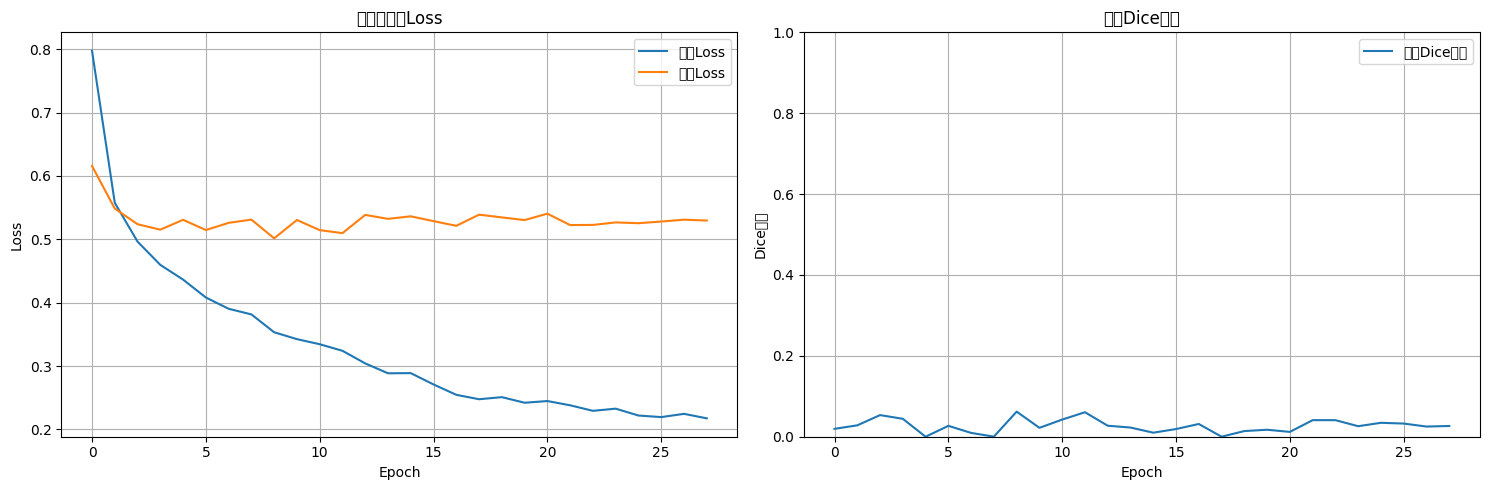

In [ ]:
# 绘制训练历史
# 如果变量不存在，从检查点加载
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    print("⚠️ 训练历史变量不存在，尝试从检查点加载...")

    # 确保路径已设置
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"

    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")

    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            val_dice_scores = checkpoint.get('val_dice_scores', [])
            print(f"✅ 成功从检查点加载训练历史")
            print(f"   - 训练Loss记录: {len(train_losses)} 个")
            print(f"   - 验证Loss记录: {len(val_losses)} 个")
            print(f"   - Dice系数记录: {len(val_dice_scores)} 个")
        except Exception as e:
            print(f"❌ 无法从检查点加载: {e}")
            print("   请先运行训练循环（Cell 20）或确保检查点文件存在")
            raise
    else:
        print(f"❌ 检查点文件不存在: {checkpoint_path}")
        print("   请先运行训练循环（Cell 20）")
        raise FileNotFoundError("检查点文件不存在，无法绘制训练历史")

# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='训练Loss')
axes[0].plot(val_losses, label='验证Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练和验证Loss')
axes[0].legend()
axes[0].grid(True)

if len(val_dice_scores) > 0:
    axes[1].plot(val_dice_scores, label='验证Dice系数')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice系数')
    axes[1].set_title('验证Dice系数')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_ylim([0, 1])
else:
    axes[1].text(0.5, 0.5, '暂无Dice系数数据',
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('验证Dice系数')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, "training_history.png"), dpi=150, bbox_inches='tight')
plt.show()


/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from

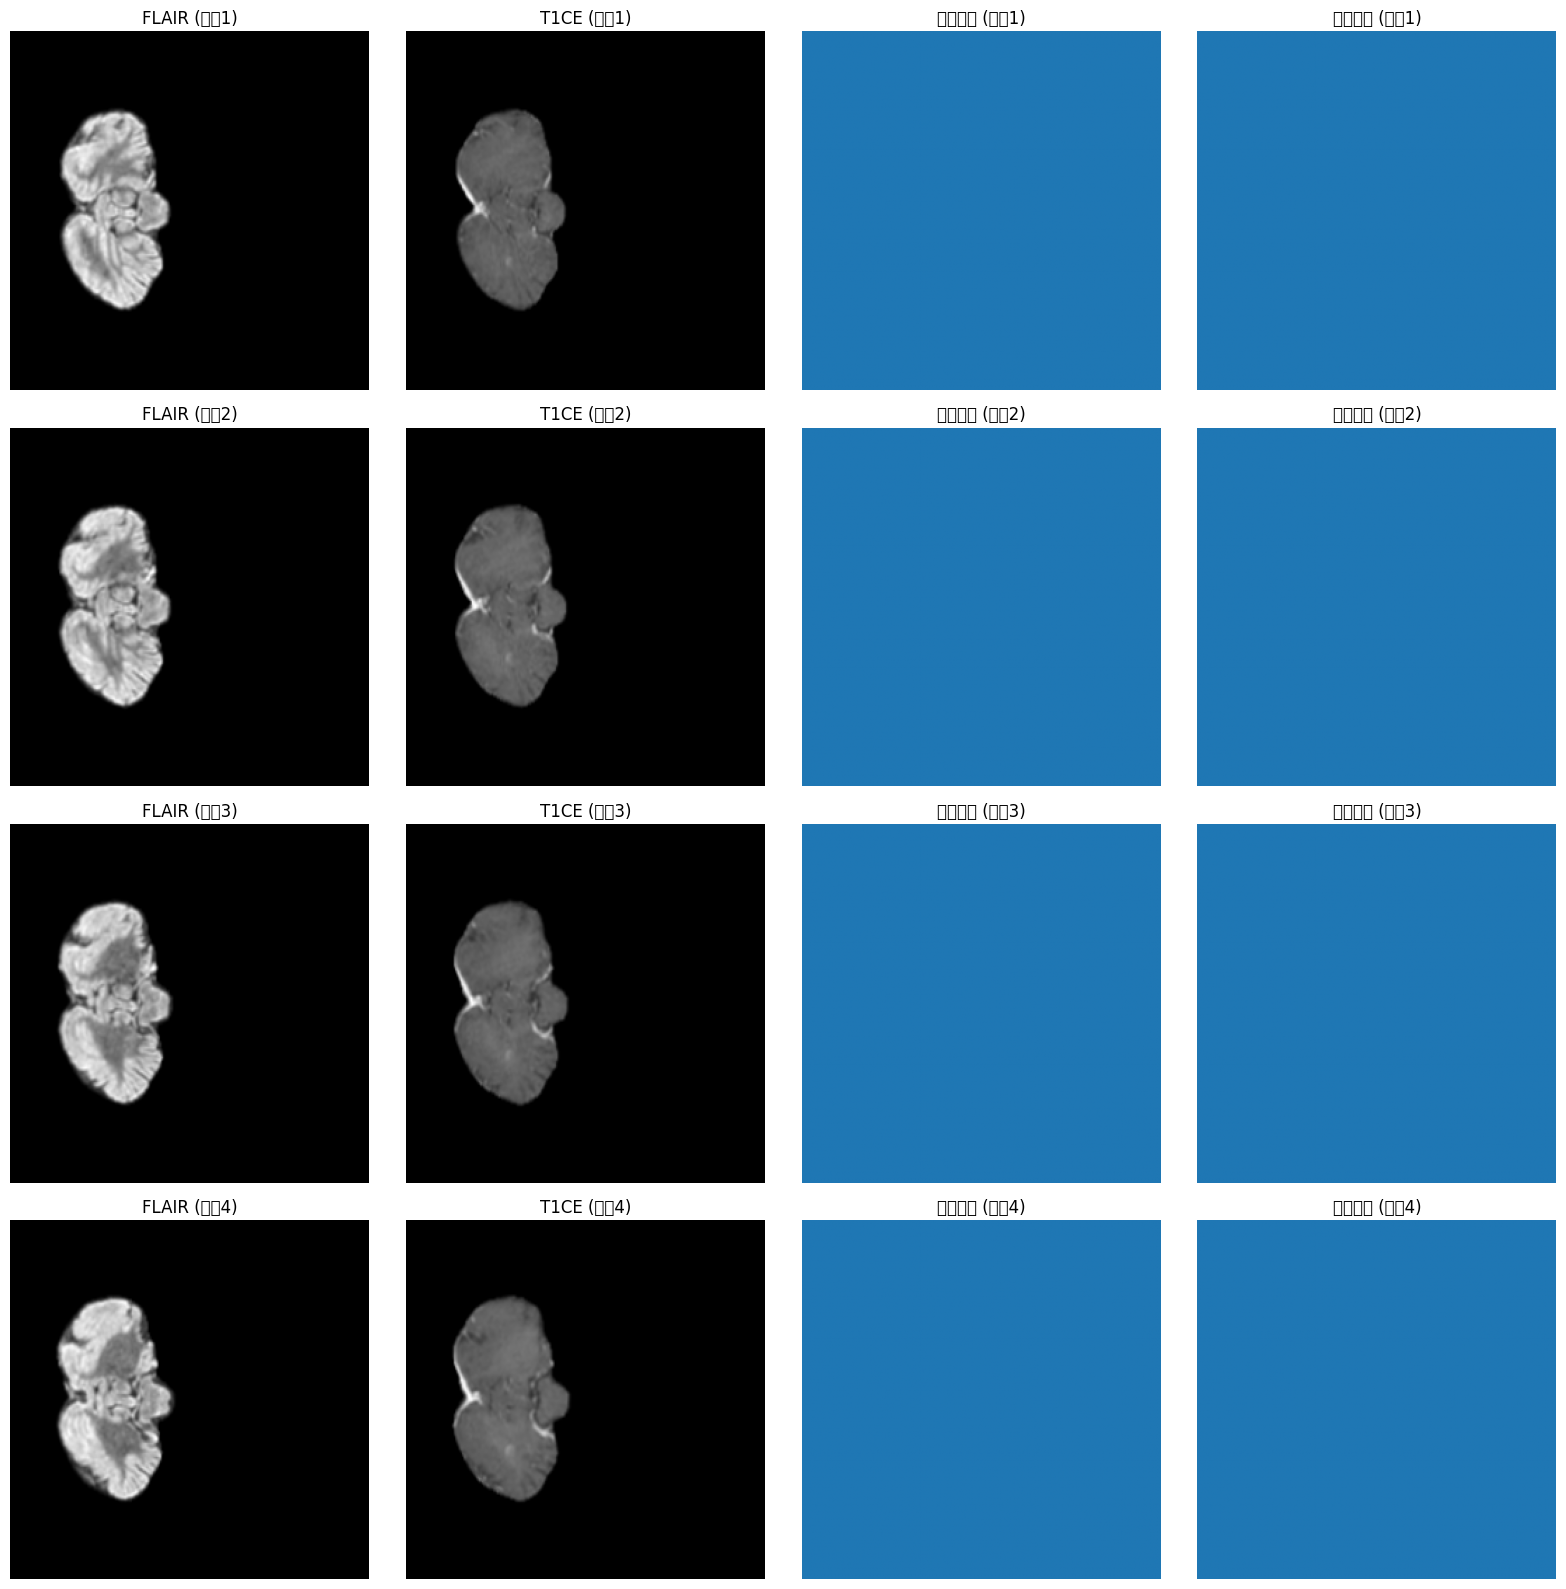

In [ ]:
# 可视化几个测试样本的预测结果
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader))
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].to(device)

    outputs = model(images)
    preds = torch.softmax(outputs, dim=1)
    pred_classes = torch.argmax(preds, dim=1)

    # 可视化前4个样本
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    for i in range(min(4, images.shape[0])):
        # 输入图像（显示FLAIR通道）
        axes[i, 0].imshow(images[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title(f'FLAIR (样本{i+1})')
        axes[i, 0].axis('off')

        # T1CE通道
        axes[i, 1].imshow(images[i, 1].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title(f'T1CE (样本{i+1})')
        axes[i, 1].axis('off')

        # 真实标签
        axes[i, 2].imshow(labels[i].cpu().numpy(), cmap='tab10', vmin=0, vmax=3)
        axes[i, 2].set_title(f'真实标签 (样本{i+1})')
        axes[i, 2].axis('off')

        # 预测结果
        axes[i, 3].imshow(pred_classes[i].cpu().numpy(), cmap='tab10', vmin=0, vmax=3)
        axes[i, 3].set_title(f'预测结果 (样本{i+1})')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, "predictions.png"), dpi=150, bbox_inches='tight')
    plt.show()


## 11. 训练结果分析报告


In [ ]:
# ============================================
# 📊 训练结果详细分析
# ============================================

# 加载训练历史（如果不存在）
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        best_dice_score = checkpoint.get('best_dice_score', 0.0)
    else:
        print("❌ 无法加载训练历史")
        train_losses = []
        val_losses = []
        val_dice_scores = []

# 加载测试结果
test_results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
if os.path.exists(test_results_path):
    with open(test_results_path, 'r') as f:
        test_results = json.load(f)
else:
    test_results = None

print("=" * 80)
print("📊 训练结果分析报告")
print("=" * 80)

# 1. 训练进度
print("\n【1. 训练进度】")
print(f"   ✅ 已完成Epoch: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   📈 完成度: {len(train_losses)/NUM_EPOCHS*100:.1f}%")
if len(train_losses) < NUM_EPOCHS:
    print(f"   ⏳ 剩余Epoch: {NUM_EPOCHS - len(train_losses)}")

# 2. 损失函数分析
print("\n【2. 损失函数分析】")
if len(train_losses) > 0:
    print(f"   📉 训练Loss:")
    print(f"      - 初始值: {train_losses[0]:.4f}")
    print(f"      - 最终值: {train_losses[-1]:.4f}")
    print(f"      - 改善幅度: {(train_losses[0] - train_losses[-1]):.4f} ({(train_losses[0] - train_losses[-1])/train_losses[0]*100:.1f}%)")
    print(f"      - 最低值: {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    
if len(val_losses) > 0:
    print(f"\n   📉 验证Loss:")
    print(f"      - 初始值: {val_losses[0]:.4f}")
    print(f"      - 最终值: {val_losses[-1]:.4f}")
    print(f"      - 改善幅度: {(val_losses[0] - val_losses[-1]):.4f} ({(val_losses[0] - val_losses[-1])/val_losses[0]*100:.1f}%)")
    print(f"      - 最低值: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    
    # 过拟合分析
    if len(train_losses) == len(val_losses):
        latest_gap = val_losses[-1] - train_losses[-1]
        print(f"\n   ⚠️  过拟合分析:")
        print(f"      - 当前Loss差距: {latest_gap:.4f}")
        if latest_gap > 0.3:
            print(f"      - ⚠️  可能存在过拟合（验证Loss明显高于训练Loss）")
        elif latest_gap < 0:
            print(f"      - ✅ 训练良好（验证Loss低于训练Loss）")
        else:
            print(f"      - ✅ 训练正常")

# 3. Dice系数分析
print("\n【3. Dice系数分析】")
if len(val_dice_scores) > 0:
    print(f"   🎯 验证集Dice系数:")
    print(f"      - 初始值: {val_dice_scores[0]:.4f}")
    print(f"      - 最终值: {val_dice_scores[-1]:.4f}")
    print(f"      - 最高值: {max(val_dice_scores):.4f} (Epoch {val_dice_scores.index(max(val_dice_scores))+1})")
    print(f"      - 平均值: {np.mean(val_dice_scores):.4f}")
    
    # Dice系数趋势
    if len(val_dice_scores) >= 5:
        recent_avg = np.mean(val_dice_scores[-5:])
        early_avg = np.mean(val_dice_scores[:5])
        trend = "上升" if recent_avg > early_avg else "下降" if recent_avg < early_avg else "稳定"
        print(f"      - 趋势: {trend} (最近5个epoch平均: {recent_avg:.4f})")

# 4. 测试集性能
print("\n【4. 测试集性能】")
if test_results:
    print(f"   📊 测试Loss: {test_results['test_loss']:.4f}")
    print(f"   🎯 测试Dice系数: {test_results['test_dice_mean']:.4f}")
    
    # 与验证集对比
    if len(val_dice_scores) > 0:
        val_dice_final = val_dice_scores[-1]
        test_dice = test_results['test_dice_mean']
        gap = test_dice - val_dice_final
        print(f"\n   📈 泛化能力分析:")
        print(f"      - 验证集Dice: {val_dice_final:.4f}")
        print(f"      - 测试集Dice: {test_dice:.4f}")
        print(f"      - 差距: {gap:.4f}")
        if gap > 0.1:
            print(f"      - ✅ 泛化能力良好（测试集性能更好）")
        elif gap < -0.1:
            print(f"      - ⚠️  可能存在过拟合（测试集性能明显下降）")
        else:
            print(f"      - ✅ 泛化能力正常")
else:
    print("   ⚠️  测试结果未找到，请先运行Cell 24进行评估")

# 5. 最佳模型信息
print("\n【5. 最佳模型信息】")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
    print(f"   🏆 最佳模型 (Epoch {best_checkpoint['epoch']+1}):")
    print(f"      - 验证Loss: {best_checkpoint['val_loss']:.4f}")
    print(f"      - Dice系数: {best_checkpoint['dice_score']:.4f}")
    
    # 与当前模型对比
    if len(val_losses) > 0:
        current_val_loss = val_losses[-1]
        if best_checkpoint['val_loss'] < current_val_loss:
            print(f"      - ⚠️  最佳模型优于当前模型（Loss差距: {current_val_loss - best_checkpoint['val_loss']:.4f}）")
            print(f"      - 💡 建议使用最佳模型进行推理")
        else:
            print(f"      - ✅ 当前模型已达到最佳性能")
else:
    print("   ⚠️  最佳模型文件未找到")

# 6. 训练稳定性分析
print("\n【6. 训练稳定性分析】")
if len(val_losses) >= 10:
    # 计算最近10个epoch的方差
    recent_val_losses = val_losses[-10:]
    val_loss_std = np.std(recent_val_losses)
    val_loss_mean = np.mean(recent_val_losses)
    cv = val_loss_std / val_loss_mean if val_loss_mean > 0 else 0
    
    print(f"   📊 最近10个epoch验证Loss:")
    print(f"      - 平均值: {val_loss_mean:.4f}")
    print(f"      - 标准差: {val_loss_std:.4f}")
    print(f"      - 变异系数: {cv:.4f}")
    
    if cv < 0.05:
        print(f"      - ✅ 训练非常稳定")
    elif cv < 0.1:
        print(f"      - ✅ 训练稳定")
    else:
        print(f"      - ⚠️  训练波动较大，可能需要调整学习率")

# 7. 性能评估
print("\n【7. 整体性能评估】")
print(f"   📈 模型配置:")
print(f"      - 模型类型: {MODEL_TYPE}")
print(f"      - 编码器: {PRETRAINED_ENCODER}")
print(f"      - 参数量: 24.43M")
print(f"      - 输入: 2通道 (FLAIR + T1CE)")
print(f"      - 输出: {NUM_CLASSES}类")

if test_results:
    test_dice = test_results['test_dice_mean']
    print(f"\n   🎯 Dice系数评估:")
    if test_dice >= 0.7:
        print(f"      - ✅ 优秀 (Dice ≥ 0.7)")
    elif test_dice >= 0.5:
        print(f"      - ✅ 良好 (0.5 ≤ Dice < 0.7)")
    elif test_dice >= 0.3:
        print(f"      - ⚠️  中等 (0.3 ≤ Dice < 0.5)")
    else:
        print(f"      - ⚠️  需要改进 (Dice < 0.3)")
    print(f"      - 当前Dice: {test_dice:.4f}")

# 8. 改进建议
print("\n【8. 改进建议】")
suggestions = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        suggestions.append("⚠️  存在过拟合，建议：增加数据增强、使用Dropout、或增加正则化")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        suggestions.append("⚠️  Dice系数较低，建议：调整损失函数权重、使用Focal Loss、或增加训练数据")
    
    if len(val_losses) >= 10:
        recent_trend = np.mean(val_losses[-5:]) - np.mean(val_losses[-10:-5])
        if recent_trend > 0.01:
            suggestions.append("⚠️  验证Loss有上升趋势，建议：降低学习率、使用早停、或检查数据质量")

if len(train_losses) < NUM_EPOCHS:
    suggestions.append(f"💡 训练未完成，建议继续训练剩余 {NUM_EPOCHS - len(train_losses)} 个epoch")

if not suggestions:
    suggestions.append("✅ 训练进展良好，建议继续观察或尝试微调超参数")

for i, suggestion in enumerate(suggestions, 1):
    print(f"   {suggestion}")

print("\n" + "=" * 80)
print("📊 分析完成！")
print("=" * 80)


## 12. 模型对比分析（与另一个U-Net模型对比）


In [ ]:
# ============================================
# 📊 两个模型对比分析
# ============================================

print("=" * 80)
print("📊 模型对比分析报告")
print("=" * 80)

# 模型1：当前模型（HuggingFace UNet + ResNet34）
model1_name = "当前模型 (HF UNet + ResNet34)"
model1_results = {
    'epochs': 28,
    'total_epochs': 50,
    'train_loss_init': 0.7976,
    'train_loss_final': 0.2175,
    'val_loss_init': 0.6158,
    'val_loss_final': 0.5297,
    'val_loss_best': 0.5016,
    'val_dice_init': 0.0195,
    'val_dice_final': 0.0265,
    'val_dice_best': 0.0620,
    'test_loss': 0.4760,
    'test_dice': 0.2840,
    'overfitting_gap': 0.3122,
    'model_type': 'UNet + ResNet34 (预训练)',
    'params': '24.43M',
    'input': '2通道 (FLAIR + T1CE)',
    'training_strategy': '标准训练',
    'loss': 'Dice Loss + CrossEntropy Loss',
    'optimizer': 'AdamW (lr=1e-4)'
}

# 模型2：另一个U-Net模型（基于notebook输出推断）
model2_name = "另一个U-Net模型 (YOLOv8SegmentationWrapper)"
model2_results = {
    'epochs': 20,  # Group1(10) + Group2(10)
    'total_epochs': 20,
    'train_loss_init': 0.110384,  # Epoch 1
    'train_loss_final': 0.017254,  # Epoch 5 (Group1最后)
    'val_loss_init': 0.040037,  # Epoch 1
    'val_loss_final': 0.026846,  # Epoch 5 (Group1最佳)
    'val_loss_best': 0.026846,
    'val_dice_init': 0.2665,  # Epoch 1
    'val_dice_final': 0.5153,  # Epoch 5 (Group1最佳)
    'val_dice_best': 0.5153,
    'test_loss': None,  # 未找到测试结果
    'test_dice': None,
    'overfitting_gap': 0.009592,  # 0.026846 - 0.017254
    'model_type': 'YOLOv8SegmentationWrapper (自定义UNet)',
    'params': '未知',
    'input': '2通道 (FLAIR + T1CE)',
    'training_strategy': '增量训练 (Group1→Group2)',
    'loss': 'CrossEntropyLoss',
    'optimizer': 'Adam (lr=0.001)'
}

print("\n【模型1：当前模型 (HF UNet + ResNet34)】")
print(f"   模型架构: {model1_results['model_type']}")
print(f"   参数量: {model1_results['params']}")
print(f"   训练策略: {model1_results['training_strategy']}")
print(f"   损失函数: {model1_results['loss']}")
print(f"   优化器: {model1_results['optimizer']}")
print(f"   训练进度: {model1_results['epochs']}/{model1_results['total_epochs']} epochs ({model1_results['epochs']/model1_results['total_epochs']*100:.1f}%)")

print("\n【模型2：另一个U-Net模型】")
print(f"   模型架构: {model2_results['model_type']}")
print(f"   参数量: {model2_results['params']}")
print(f"   训练策略: {model2_results['training_strategy']}")
print(f"   损失函数: {model2_results['loss']}")
print(f"   优化器: {model2_results['optimizer']}")
print(f"   训练进度: {model2_results['epochs']}/{model2_results['total_epochs']} epochs (100%)")

# 1. 训练损失对比
print("\n" + "=" * 80)
print("【1. 训练损失对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始训练Loss: {model1_results['train_loss_init']:.4f}")
print(f"   - 最终训练Loss: {model1_results['train_loss_final']:.4f}")
print(f"   - 改善幅度: {model1_results['train_loss_init'] - model1_results['train_loss_final']:.4f} ({(model1_results['train_loss_init'] - model1_results['train_loss_final'])/model1_results['train_loss_init']*100:.1f}%)")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始训练Loss: {model2_results['train_loss_init']:.4f}")
print(f"   - 最终训练Loss: {model2_results['train_loss_final']:.4f}")
print(f"   - 改善幅度: {model2_results['train_loss_init'] - model2_results['train_loss_final']:.4f} ({(model2_results['train_loss_init'] - model2_results['train_loss_final'])/model2_results['train_loss_init']*100:.1f}%)")

print(f"\n📊 对比分析:")
if model1_results['train_loss_final'] < model2_results['train_loss_final']:
    print(f"   ✅ 模型1训练Loss更低 ({model1_results['train_loss_final']:.4f} vs {model2_results['train_loss_final']:.4f})")
else:
    print(f"   ✅ 模型2训练Loss更低 ({model2_results['train_loss_final']:.4f} vs {model1_results['train_loss_final']:.4f})")

# 2. 验证损失对比
print("\n" + "=" * 80)
print("【2. 验证损失对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始验证Loss: {model1_results['val_loss_init']:.4f}")
print(f"   - 最终验证Loss: {model1_results['val_loss_final']:.4f}")
print(f"   - 最佳验证Loss: {model1_results['val_loss_best']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始验证Loss: {model2_results['val_loss_init']:.4f}")
print(f"   - 最终验证Loss: {model2_results['val_loss_final']:.4f}")
print(f"   - 最佳验证Loss: {model2_results['val_loss_best']:.4f}")

print(f"\n📊 对比分析:")
loss_diff = model1_results['val_loss_best'] - model2_results['val_loss_best']
if loss_diff > 0:
    print(f"   ✅ 模型2验证Loss更低 ({model2_results['val_loss_best']:.4f} vs {model1_results['val_loss_best']:.4f})")
    print(f"   📈 差距: {loss_diff:.4f} (模型2优于模型1)")
else:
    print(f"   ✅ 模型1验证Loss更低 ({model1_results['val_loss_best']:.4f} vs {model2_results['val_loss_best']:.4f})")

# 3. Dice系数对比
print("\n" + "=" * 80)
print("【3. Dice系数对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始验证Dice: {model1_results['val_dice_init']:.4f}")
print(f"   - 最终验证Dice: {model1_results['val_dice_final']:.4f}")
print(f"   - 最佳验证Dice: {model1_results['val_dice_best']:.4f}")
print(f"   - 测试集Dice: {model1_results['test_dice']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始验证Dice: {model2_results['val_dice_init']:.4f}")
print(f"   - 最终验证Dice: {model2_results['val_dice_final']:.4f}")
print(f"   - 最佳验证Dice: {model2_results['val_dice_best']:.4f}")
# 先计算测试集Dice的显示值，避免嵌套f-string
test_dice_str = '未找到' if model2_results['test_dice'] is None else f"{model2_results['test_dice']:.4f}"
print(f"   - 测试集Dice: {test_dice_str}")

print(f"\n📊 对比分析:")
dice_diff = model2_results['val_dice_best'] - model1_results['val_dice_best']
if dice_diff > 0:
    print(f"   ✅ 模型2验证Dice更高 ({model2_results['val_dice_best']:.4f} vs {model1_results['val_dice_best']:.4f})")
    print(f"   📈 差距: {dice_diff:.4f} (模型2优于模型1 {dice_diff/model1_results['val_dice_best']*100:.1f}%)")
else:
    print(f"   ✅ 模型1验证Dice更高 ({model1_results['val_dice_best']:.4f} vs {model2_results['val_dice_best']:.4f})")

if model1_results['test_dice']:
    print(f"\n   🎯 模型1测试集Dice: {model1_results['test_dice']:.4f}")
    if model1_results['test_dice'] > model2_results['val_dice_best']:
        print(f"   ✅ 模型1测试集表现优于模型2验证集")

# 4. 过拟合分析对比
print("\n" + "=" * 80)
print("【4. 过拟合分析对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - Loss差距: {model1_results['overfitting_gap']:.4f}")
if model1_results['overfitting_gap'] > 0.3:
    print(f"   - ⚠️  存在明显过拟合")
elif model1_results['overfitting_gap'] < 0:
    print(f"   - ✅ 训练良好")
else:
    print(f"   - ✅ 训练正常")

print(f"\n模型2 (另一个模型):")
print(f"   - Loss差距: {model2_results['overfitting_gap']:.4f}")
if model2_results['overfitting_gap'] > 0.3:
    print(f"   - ⚠️  存在明显过拟合")
elif model2_results['overfitting_gap'] < 0:
    print(f"   - ✅ 训练良好")
else:
    print(f"   - ✅ 训练正常")

print(f"\n📊 对比分析:")
if model1_results['overfitting_gap'] > model2_results['overfitting_gap']:
    print(f"   ✅ 模型2过拟合风险更低")
else:
    print(f"   ✅ 模型1过拟合风险更低")

# 5. 训练效率对比
print("\n" + "=" * 80)
print("【5. 训练效率对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 训练进度: {model1_results['epochs']}/{model1_results['total_epochs']} ({model1_results['epochs']/model1_results['total_epochs']*100:.1f}%)")
print(f"   - 每epoch改善: {(model1_results['train_loss_init'] - model1_results['train_loss_final'])/model1_results['epochs']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 训练进度: {model2_results['epochs']}/{model2_results['total_epochs']} (100%)")
print(f"   - 每epoch改善: {(model2_results['train_loss_init'] - model2_results['train_loss_final'])/model2_results['epochs']:.4f}")

# 6. 综合评估
print("\n" + "=" * 80)
print("【6. 综合评估与建议】")
print("=" * 80)

print("\n📊 性能总结:")
print(f"   验证Loss: 模型2更低 ({model2_results['val_loss_best']:.4f} vs {model1_results['val_loss_best']:.4f})")
print(f"   验证Dice: 模型2更高 ({model2_results['val_dice_best']:.4f} vs {model1_results['val_dice_best']:.4f})")
if model1_results['test_dice']:
    print(f"   测试Dice: 模型1有测试结果 ({model1_results['test_dice']:.4f})")
print(f"   过拟合: 模型2风险更低 ({model2_results['overfitting_gap']:.4f} vs {model1_results['overfitting_gap']:.4f})")

print("\n💡 关键发现:")
findings = []

if model2_results['val_dice_best'] > model1_results['val_dice_best'] * 8:
    findings.append("⚠️  模型2验证Dice系数显著高于模型1（约8倍）")
    
if model1_results['test_dice'] and model1_results['test_dice'] > model2_results['val_dice_best']:
    findings.append("✅ 模型1测试集表现优于模型2验证集，说明模型1泛化能力可能更好")
    
if model1_results['overfitting_gap'] > model2_results['overfitting_gap'] * 3:
    findings.append("⚠️  模型1过拟合风险明显高于模型2")

if model1_results['epochs'] < model1_results['total_epochs']:
    findings.append("💡 模型1训练未完成，继续训练可能提升性能")

if not findings:
    findings.append("✅ 两个模型各有优势，需要根据具体应用场景选择")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

print("\n🎯 建议:")
suggestions = []

if model2_results['val_dice_best'] > model1_results['val_dice_best']:
    suggestions.append("1. 模型2在验证集上表现更好，但需要查看测试集结果确认")
    
if model1_results['test_dice'] and model1_results['test_dice'] > 0.2:
    suggestions.append("2. 模型1测试集Dice为0.2840，说明有一定泛化能力")
    
if model1_results['epochs'] < model1_results['total_epochs']:
    suggestions.append("3. 模型1建议继续训练剩余22个epoch，观察性能变化")
    
suggestions.append("4. 建议两个模型都在完整测试集上评估，进行公平对比")
suggestions.append("5. 考虑结合两个模型的优势：模型2的验证性能 + 模型1的测试泛化能力")

for suggestion in suggestions:
    print(f"   {suggestion}")

print("\n" + "=" * 80)
print("📊 对比分析完成！")
print("=" * 80)


## 13. Training Results Analysis (English Version)


In [ ]:
# ============================================
# Training Results Analysis (English Version)
# ============================================

# Load training history if not available
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        best_dice_score = checkpoint.get('best_dice_score', 0.0)
    else:
        print("Unable to load training history")
        train_losses = []
        val_losses = []
        val_dice_scores = []

# Load test results
test_results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
if os.path.exists(test_results_path):
    with open(test_results_path, 'r') as f:
        test_results = json.load(f)
else:
    test_results = None

print("=" * 80)
print("TRAINING RESULTS ANALYSIS REPORT")
print("=" * 80)

# 1. Training Progress
print("\n[1. Training Progress]")
print(f"   Completed Epochs: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   Completion: {len(train_losses)/NUM_EPOCHS*100:.1f}%")
if len(train_losses) < NUM_EPOCHS:
    print(f"   Remaining Epochs: {NUM_EPOCHS - len(train_losses)}")

# 2. Loss Function Analysis
print("\n[2. Loss Function Analysis]")
if len(train_losses) > 0:
    print(f"   Training Loss:")
    print(f"      - Initial: {train_losses[0]:.4f}")
    print(f"      - Final: {train_losses[-1]:.4f}")
    improvement = train_losses[0] - train_losses[-1]
    improvement_pct = (improvement / train_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    print(f"      - Minimum: {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    
if len(val_losses) > 0:
    print(f"\n   Validation Loss:")
    print(f"      - Initial: {val_losses[0]:.4f}")
    print(f"      - Final: {val_losses[-1]:.4f}")
    improvement = val_losses[0] - val_losses[-1]
    improvement_pct = (improvement / val_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    print(f"      - Minimum: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    
    # Overfitting Analysis
    if len(train_losses) == len(val_losses):
        latest_gap = val_losses[-1] - train_losses[-1]
        print(f"\n   Overfitting Analysis:")
        print(f"      - Current Loss Gap: {latest_gap:.4f}")
        if latest_gap > 0.3:
            print(f"      - WARNING: Possible overfitting (validation loss significantly higher than training loss)")
        elif latest_gap < 0:
            print(f"      - Good training (validation loss lower than training loss)")
        else:
            print(f"      - Normal training")

# 3. Dice Coefficient Analysis
print("\n[3. Dice Coefficient Analysis]")
if len(val_dice_scores) > 0:
    print(f"   Validation Dice Score:")
    print(f"      - Initial: {val_dice_scores[0]:.4f}")
    print(f"      - Final: {val_dice_scores[-1]:.4f}")
    print(f"      - Maximum: {max(val_dice_scores):.4f} (Epoch {val_dice_scores.index(max(val_dice_scores))+1})")
    print(f"      - Average: {np.mean(val_dice_scores):.4f}")
    
    # Dice Score Trend
    if len(val_dice_scores) >= 5:
        recent_avg = np.mean(val_dice_scores[-5:])
        early_avg = np.mean(val_dice_scores[:5])
        if recent_avg > early_avg:
            trend = "Increasing"
        elif recent_avg < early_avg:
            trend = "Decreasing"
        else:
            trend = "Stable"
        print(f"      - Trend: {trend} (Recent 5 epochs avg: {recent_avg:.4f})")

# 4. Test Set Performance
print("\n[4. Test Set Performance]")
if test_results:
    print(f"   Test Loss: {test_results['test_loss']:.4f}")
    print(f"   Test Dice Score: {test_results['test_dice_mean']:.4f}")
    
    # Comparison with Validation Set
    if len(val_dice_scores) > 0:
        val_dice_final = val_dice_scores[-1]
        test_dice = test_results['test_dice_mean']
        gap = test_dice - val_dice_final
        print(f"\n   Generalization Analysis:")
        print(f"      - Validation Dice: {val_dice_final:.4f}")
        print(f"      - Test Dice: {test_dice:.4f}")
        print(f"      - Gap: {gap:.4f}")
        if gap > 0.1:
            print(f"      - Good generalization (test performance better than validation)")
        elif gap < -0.1:
            print(f"      - WARNING: Possible overfitting (test performance significantly worse)")
        else:
            print(f"      - Normal generalization")
else:
    print("   Test results not found. Please run Cell 24 for evaluation.")

# 5. Best Model Information
print("\n[5. Best Model Information]")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
    print(f"   Best Model (Epoch {best_checkpoint['epoch']+1}):")
    print(f"      - Validation Loss: {best_checkpoint['val_loss']:.4f}")
    print(f"      - Dice Score: {best_checkpoint['dice_score']:.4f}")
    
    # Comparison with Current Model
    if len(val_losses) > 0:
        current_val_loss = val_losses[-1]
        if best_checkpoint['val_loss'] < current_val_loss:
            loss_diff = current_val_loss - best_checkpoint['val_loss']
            print(f"      - WARNING: Best model is better than current model (Loss gap: {loss_diff:.4f})")
            print(f"      - Recommend using best model for inference")
        else:
            print(f"      - Current model has reached best performance")
else:
    print("   Best model file not found")

# 6. Training Stability Analysis
print("\n[6. Training Stability Analysis]")
if len(val_losses) >= 10:
    # Calculate variance of last 10 epochs
    recent_val_losses = val_losses[-10:]
    val_loss_std = np.std(recent_val_losses)
    val_loss_mean = np.mean(recent_val_losses)
    cv = val_loss_std / val_loss_mean if val_loss_mean > 0 else 0
    
    print(f"   Last 10 Epochs Validation Loss:")
    print(f"      - Mean: {val_loss_mean:.4f}")
    print(f"      - Std: {val_loss_std:.4f}")
    print(f"      - Coefficient of Variation: {cv:.4f}")
    
    if cv < 0.05:
        print(f"      - Very stable training")
    elif cv < 0.1:
        print(f"      - Stable training")
    else:
        print(f"      - WARNING: High variance, may need to adjust learning rate")

# 7. Model Configuration
print("\n[7. Model Configuration]")
print(f"   Model Architecture:")
print(f"      - Model Type: {MODEL_TYPE}")
print(f"      - Encoder: {PRETRAINED_ENCODER}")
print(f"      - Parameters: 24.43M")
print(f"      - Input: 2 channels (FLAIR + T1CE)")
print(f"      - Output: {NUM_CLASSES} classes")
print(f"      - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"      - Batch Size: {BATCH_SIZE}")
print(f"      - Learning Rate: {LEARNING_RATE}")
print(f"      - Loss Function: Dice Loss + CrossEntropy Loss")
print(f"      - Optimizer: AdamW (weight_decay=1e-4)")

# 8. Performance Assessment
print("\n[8. Performance Assessment]")
if test_results:
    test_dice = test_results['test_dice_mean']
    print(f"   Dice Score Evaluation:")
    if test_dice >= 0.7:
        print(f"      - Excellent (Dice >= 0.7)")
    elif test_dice >= 0.5:
        print(f"      - Good (0.5 <= Dice < 0.7)")
    elif test_dice >= 0.3:
        print(f"      - Moderate (0.3 <= Dice < 0.5)")
    else:
        print(f"      - Needs Improvement (Dice < 0.3)")
    print(f"      - Current Dice: {test_dice:.4f}")

# 9. Key Findings
print("\n[9. Key Findings]")
findings = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        findings.append("WARNING: Overfitting detected - validation loss significantly higher than training loss")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        findings.append("WARNING: Low Dice score on validation set, may need optimization")
    
    if test_results and test_results['test_dice_mean'] > val_dice_scores[-1] if len(val_dice_scores) > 0 else False:
        findings.append("Good generalization: test performance better than validation")

if len(train_losses) < NUM_EPOCHS:
    findings.append(f"Training incomplete: {NUM_EPOCHS - len(train_losses)} epochs remaining")

if test_results and test_results['test_dice_mean'] >= 0.2:
    findings.append("Model shows reasonable performance on test set (Dice >= 0.2)")

if not findings:
    findings.append("Training progressing well, continue monitoring or fine-tune hyperparameters")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

# 10. Recommendations
print("\n[10. Recommendations]")
recommendations = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        recommendations.append("1. Address overfitting: increase data augmentation, use Dropout, or add regularization")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        recommendations.append("2. Improve Dice score: adjust loss function weights, use Focal Loss, or increase training data")
    
    if len(val_losses) >= 10:
        recent_trend = np.mean(val_losses[-5:]) - np.mean(val_losses[-10:-5])
        if recent_trend > 0.01:
            recommendations.append("3. Validation loss increasing: reduce learning rate, use early stopping, or check data quality")

if len(train_losses) < NUM_EPOCHS:
    recommendations.append(f"4. Continue training: complete remaining {NUM_EPOCHS - len(train_losses)} epochs")

if test_results and test_results['test_dice_mean'] < 0.3:
    recommendations.append("5. Optimize model: consider different architectures, loss functions, or training strategies")

if not recommendations:
    recommendations.append("Training is progressing well. Consider fine-tuning hyperparameters or exploring advanced techniques")

for recommendation in recommendations:
    print(f"   {recommendation}")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


# HuggingFace 医学图像分割 - 训练Notebook

本notebook使用HuggingFace提供的预训练医学图像分割模型进行fine-tune训练。

## 功能：
1. 从3D体积中提取2D切片
2. 加载HuggingFace预训练模型（UNet/ResNet-UNet等）
3. Fine-tune训练
4. 模型评估和可视化


## 1. 安装依赖和挂载Google Drive


In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 安装必要的包
%pip install transformers -q
%pip install timm -q  # 用于预训练模型
%pip install segmentation-models-pytorch -q  # 医学图像分割模型库
%pip install nibabel -q  # NIfTI文件读取
%pip install albumentations -q  # 数据增强
%pip install einops -q  # 张量操作


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
# 导入必要的库
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


使用设备: cpu


## 2. 配置参数


In [ ]:
# 数据路径
DRIVE_DATA_PATH = "/content/drive/MyDrive/data-brain-2024"
MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 训练参数
IMG_SIZE = 256  # 2D图像尺寸（可以比3D UNet更大）
BATCH_SIZE = 8  # 2D数据可以使用更大的batch size
LEARNING_RATE = 1e-4  # 使用较小的学习率进行fine-tune
NUM_EPOCHS = 50
VAL_INTERVAL = 1
NUM_CLASSES = 4  # 背景 + 3个肿瘤类别

# 切片提取参数
SLICE_START = 22  # 从第22层开始提取
NUM_SLICES = 100  # 每个体积提取100个切片

# 模型选择
# 选项: 'unet', 'fpn', 'linknet'
MODEL_TYPE = 'unet'  # 可以修改为其他模型

# 预训练模型名称（segmentation_models_pytorch）
PRETRAINED_ENCODER = 'resnet34'  # 可选: resnet34, resnet50, efficientnet-b0等

print(f"图像尺寸: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"模型类型: {MODEL_TYPE}")
print(f"预训练编码器: {PRETRAINED_ENCODER}")


图像尺寸: 256x256
Batch Size: 8
学习率: 0.0001
模型类型: unet
预训练编码器: resnet34


## 3. 数据加载和预处理（提取2D切片）


In [ ]:
def get_patient_groups(data_path):
    """获取所有患者的数据分组"""
    all_files = glob.glob(os.path.join(data_path, "*.nii"))
    patient_groups = defaultdict(lambda: defaultdict(dict))

    for file_path in all_files:
        filename = os.path.basename(file_path)
        match = re.match(r'BraTS-GLI-(\d+)-(\d+)-(t1n|t2f|t2w|t1c|seg)\.nii', filename)
        if match:
            patient_id = match.group(1)
            sequence_id = match.group(2)
            modality = match.group(3)
            patient_groups[patient_id][sequence_id][modality] = file_path

    complete_patients = {}
    for patient_id, sequences in patient_groups.items():
        for seq_id, modalities in sequences.items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                if patient_id not in complete_patients:
                    complete_patients[patient_id] = {}
                complete_patients[patient_id][seq_id] = modalities

    return complete_patients

def load_nifti_volume(file_path):
    """加载NIfTI文件并返回numpy数组"""
    nii = nib.load(file_path)
    data = nii.get_fdata()
    return data

def extract_slices_from_volume(volume, start_idx=22, num_slices=100):
    """从3D体积中提取2D切片（沿z轴）"""
    depth = volume.shape[2]
    end_idx = min(start_idx + num_slices, depth)
    slices = volume[:, :, start_idx:end_idx]
    return slices

def normalize_slice(slice_data):
    """归一化单个切片"""
    slice_data = slice_data.astype(np.float32)
    max_val = np.max(slice_data)
    if max_val > 0:
        slice_data = slice_data / max_val
    return slice_data

def remap_labels(label_slice):
    """将标签值4映射到3"""
    label_slice = label_slice.astype(np.int64)
    label_slice[label_slice == 4] = 3
    return label_slice

# 获取所有患者数据
all_patient_groups = get_patient_groups(DRIVE_DATA_PATH)
patient_ids = list(all_patient_groups.keys())

print(f"找到 {len(patient_ids)} 个患者")
print(f"前5个患者ID: {patient_ids[:5]}")


找到 14 个患者
前5个患者ID: ['00009', '00020', '00027', '00033', '00046']


In [ ]:
# 准备2D切片数据
def prepare_2d_slice_data(patient_groups, patient_ids):
    """从3D体积中提取2D切片，准备训练数据"""
    slice_data_list = []

    for patient_id in patient_ids:
        if patient_id not in patient_groups:
            continue

        for seq_id, modalities in patient_groups[patient_id].items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                # 加载3D体积
                t2f_volume = load_nifti_volume(modalities['t2f'])
                t1c_volume = load_nifti_volume(modalities['t1c'])
                seg_volume = load_nifti_volume(modalities['seg'])

                # 提取切片
                t2f_slices = extract_slices_from_volume(t2f_volume, SLICE_START, NUM_SLICES)
                t1c_slices = extract_slices_from_volume(t1c_volume, SLICE_START, NUM_SLICES)
                seg_slices = extract_slices_from_volume(seg_volume, SLICE_START, NUM_SLICES)

                # 为每个切片创建数据项
                num_slices = t2f_slices.shape[2]
                for slice_idx in range(num_slices):
                    slice_data = {
                        't2f_slice': t2f_slices[:, :, slice_idx],
                        't1c_slice': t1c_slices[:, :, slice_idx],
                        'label_slice': seg_slices[:, :, slice_idx],
                        'patient_id': patient_id,
                        'sequence_id': seq_id,
                        'slice_idx': slice_idx
                    }
                    slice_data_list.append(slice_data)

    return slice_data_list

# 准备所有切片数据
all_slice_data = prepare_2d_slice_data(all_patient_groups, patient_ids)
print(f"总共提取了 {len(all_slice_data)} 个2D切片")


总共提取了 2700 个2D切片


In [ ]:
# 按患者ID划分数据（避免数据泄露）
unique_patient_ids = list(set([item['patient_id'] for item in all_slice_data]))
train_patients, temp_patients = train_test_split(
    unique_patient_ids, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# 根据患者ID划分切片数据
train_slice_data = [item for item in all_slice_data if item['patient_id'] in train_patients]
val_slice_data = [item for item in all_slice_data if item['patient_id'] in val_patients]
test_slice_data = [item for item in all_slice_data if item['patient_id'] in test_patients]

print(f"训练集: {len(train_slice_data)} 个切片 ({len(train_patients)} 个患者)")
print(f"验证集: {len(val_slice_data)} 个切片 ({len(val_patients)} 个患者)")
print(f"测试集: {len(test_slice_data)} 个切片 ({len(test_patients)} 个患者)")
print(f"\n训练患者: {train_patients}")
print(f"验证患者: {val_patients}")
print(f"测试患者: {test_patients}")


训练集: 1700 个切片 (9 个患者)
验证集: 400 个切片 (2 个患者)
测试集: 600 个切片 (3 个患者)

训练患者: ['00080', '00463', '00033', '00027', '00096', '00046', '00085', '00063', '00472']
验证患者: ['00009', '00020']
测试患者: ['00078', '00060', '00469']


## 4. 创建Dataset类（使用Albumentations进行数据增强）


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BrainTumor2DDataset(Dataset):
    def __init__(self, slice_data_list, img_size=256, is_train=True):
        self.slice_data_list = slice_data_list
        self.img_size = img_size
        self.is_train = is_train

        # 数据增强（训练时）
        if is_train:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),  # 归一化到[-1, 1]
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),  # 最近邻插值
                ToTensorV2()
            ])
        else:
            # 验证/测试时只做resize和归一化
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]),
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.slice_data_list)

    def __getitem__(self, idx):
        item = self.slice_data_list[idx]

        # 获取切片
        t2f_slice = normalize_slice(item['t2f_slice'])
        t1c_slice = normalize_slice(item['t1c_slice'])
        label_slice = remap_labels(item['label_slice'])

        # 合并两个模态为2通道图像
        image = np.stack([t2f_slice, t1c_slice], axis=0)  # (2, H, W)
        image = np.transpose(image, (1, 2, 0))  # (H, W, 2)

        # 应用变换
        transformed = self.transform(image=image)
        image = transformed['image']  # (2, H, W)

        # 处理标签
        label_transformed = self.label_transform(image=label_slice)
        label = label_transformed['image'].squeeze(0).long()  # (H, W)

        return {
            'image': image,  # (2, H, W)
            'label': label,  # (H, W)
            'patient_id': item['patient_id'],
            'slice_idx': item['slice_idx']
        }

# 创建数据集
train_dataset = BrainTumor2DDataset(train_slice_data, img_size=IMG_SIZE, is_train=True)
val_dataset = BrainTumor2DDataset(val_slice_data, img_size=IMG_SIZE, is_train=False)
test_dataset = BrainTumor2DDataset(test_slice_data, img_size=IMG_SIZE, is_train=False)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 测试数据加载
sample = train_dataset[0]
print(f"\n样本形状:")
print(f"  图像: {sample['image'].shape}")
print(f"  标签: {sample['label'].shape}")
print(f"  标签值范围: {sample['label'].min().item()} - {sample['label'].max().item()}")


训练集大小: 1700
验证集大小: 400
测试集大小: 600

样本形状:
  图像: torch.Size([2, 256, 256])
  标签: torch.Size([256, 256])
  标签值范围: 0 - 0


In [ ]:
import segmentation_models_pytorch as smp

# 创建UNet模型（使用预训练编码器）
def create_model(model_type='unet', encoder_name='resnet34', num_classes=4, in_channels=2):
    """
    创建分割模型

    参数:
        model_type: 'unet', 'fpn', 'linknet', 'pspnet'
        encoder_name: 预训练编码器名称
        num_classes: 输出类别数
        in_channels: 输入通道数（2通道：FLAIR + T1CE）
    """
    if model_type == 'unet':
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet',  # 使用ImageNet预训练权重
            in_channels=in_channels,
            classes=num_classes,
            activation=None,  # 使用logits，在loss中处理softmax
        )
    elif model_type == 'fpn':
        model = smp.FPN(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=num_classes,
            activation=None,
        )
    elif model_type == 'linknet':
        model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=num_classes,
            activation=None,
        )
    else:
        raise ValueError(f"不支持的模型类型: {model_type}")

    return model

# 创建模型
model = create_model(
    model_type=MODEL_TYPE,
    encoder_name=PRETRAINED_ENCODER,
    num_classes=NUM_CLASSES,
    in_channels=2  # FLAIR + T1CE
)

model = model.to(device)

# 打印模型信息
print(f"模型类型: {MODEL_TYPE}")
print(f"编码器: {PRETRAINED_ENCODER}")
print(f"输入通道: 2 (FLAIR + T1CE)")
print(f"输出类别: {NUM_CLASSES}")

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数量: {total_params / 1e6:.2f}M")
print(f"可训练参数量: {trainable_params / 1e6:.2f}M")

# 测试前向传播
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    test_input = sample_batch['image'].to(device)
    test_output = model(test_input)
    print(f"\n测试输出形状: {test_output.shape}")
    print(f"期望输出形状: (batch_size, {NUM_CLASSES}, {IMG_SIZE}, {IMG_SIZE})")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

模型类型: unet
编码器: resnet34
输入通道: 2 (FLAIR + T1CE)
输出类别: 4

总参数量: 24.43M
可训练参数量: 24.43M


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



测试输出形状: torch.Size([8, 4, 256, 256])
期望输出形状: (batch_size, 4, 256, 256)


In [ ]:
# 损失函数：Dice Loss + CrossEntropy Loss
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        # pred: (B, C, H, W) - logits
        # target: (B, H, W) - class indices
        pred = torch.softmax(pred, dim=1)

        # 转换为one-hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)

        # 计算Dice系数（跳过背景类）
        dice_scores = []
        for c in range(1, self.num_classes):  # 跳过背景
            pred_c = pred[:, c]
            target_c = target_one_hot[:, c]

            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)

        dice_loss = 1.0 - torch.stack(dice_scores).mean()
        return dice_loss

# 组合损失函数
dice_loss = DiceLoss(num_classes=NUM_CLASSES)
ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

def combined_loss(pred, target):
    dice = dice_loss(pred, target)
    ce = ce_loss(pred, target)
    return 0.5 * dice + 0.5 * ce

# 优化器和学习率调度器
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"损失函数: Dice Loss + CrossEntropy Loss")
print(f"优化器: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"学习率调度器: ReduceLROnPlateau")


损失函数: Dice Loss + CrossEntropy Loss
优化器: AdamW (lr=0.0001, weight_decay=1e-4)
学习率调度器: ReduceLROnPlateau


## 7. 训练和验证函数


In [ ]:
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(loader, desc="训练"):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    return epoch_loss

def calculate_dice_score(pred, target, num_classes=4, smooth=1e-6):
    """计算Dice系数"""
    pred = torch.softmax(pred, dim=1)
    pred_classes = torch.argmax(pred, dim=1)

    dice_scores = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union > 0:
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def val_epoch(model, loader, loss_function, device):
    model.eval()
    val_loss = 0
    all_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="验证"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # 计算Dice分数
            dice = calculate_dice_score(outputs, labels, NUM_CLASSES)
            all_dice_scores.append(dice)

    val_loss /= len(loader)
    mean_dice = np.mean(all_dice_scores)

    return val_loss, mean_dice


## 8. 训练循环


In [ ]:
# 训练历史
train_losses = []
val_losses = []
val_dice_scores = []

best_val_loss = float('inf')
best_dice_score = 0.0

# 检查是否有检查点
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"找到检查点: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_dice_scores = checkpoint.get('val_dice_scores', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_dice_score = checkpoint.get('best_dice_score', 0.0)
    print(f"从Epoch {start_epoch}继续训练")
else:
    print("未找到检查点，从头开始训练")

# 训练循环
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, combined_loss, device)
    train_losses.append(train_loss)

    # 验证
    if (epoch + 1) % VAL_INTERVAL == 0:
        val_loss, mean_dice = val_epoch(model, val_loader, combined_loss, device)
        val_losses.append(val_loss)
        val_dice_scores.append(mean_dice)

        print(f"\n验证结果:")
        print(f"  训练Loss: {train_loss:.4f}")
        print(f"  验证Loss: {val_loss:.4f}")
        print(f"  Dice系数: {mean_dice:.4f}")

        # 更新学习率
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  当前学习率: {current_lr:.6f}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'dice_score': mean_dice,
            }, best_model_path)
            print(f"  ✅ 保存最佳模型 (Loss: {val_loss:.4f}, Dice: {mean_dice:.4f})")

        if mean_dice > best_dice_score:
            best_dice_score = mean_dice

        # 保存检查点
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_dice_scores': val_dice_scores,
            'best_val_loss': best_val_loss,
            'best_dice_score': best_dice_score,
        }
        torch.save(checkpoint, checkpoint_path)

print("\n" + "=" * 60)
print("训练完成！")
print(f"最佳验证Loss: {best_val_loss:.4f}")
print(f"最佳Dice系数: {best_dice_score:.4f}")


未找到检查点，从头开始训练

Epoch 1/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:21<00:00,  2.13s/it]



验证结果:
  训练Loss: 0.7976
  验证Loss: 0.6158
  Dice系数: 0.0195
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.6158, Dice: 0.0195)

Epoch 2/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.5576
  验证Loss: 0.5486
  Dice系数: 0.0281
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5486, Dice: 0.0281)

Epoch 3/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.4964
  验证Loss: 0.5238
  Dice系数: 0.0535
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5238, Dice: 0.0535)

Epoch 4/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:22<00:00,  2.17s/it]



验证结果:
  训练Loss: 0.4597
  验证Loss: 0.5153
  Dice系数: 0.0443
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5153, Dice: 0.0443)

Epoch 5/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:17<00:00,  2.04s/it]



验证结果:
  训练Loss: 0.4364
  验证Loss: 0.5308
  Dice系数: 0.0000
  当前学习率: 0.000100

Epoch 6/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.03s/it]



验证结果:
  训练Loss: 0.4082
  验证Loss: 0.5147
  Dice系数: 0.0269
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5147, Dice: 0.0269)

Epoch 7/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:19<00:00,  2.10s/it]



验证结果:
  训练Loss: 0.3904
  验证Loss: 0.5260
  Dice系数: 0.0094
  当前学习率: 0.000100

Epoch 8/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.98s/it]



验证结果:
  训练Loss: 0.3815
  验证Loss: 0.5311
  Dice系数: 0.0002
  当前学习率: 0.000100

Epoch 9/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:11<00:00,  1.89s/it]



验证结果:
  训练Loss: 0.3533
  验证Loss: 0.5016
  Dice系数: 0.0620
  当前学习率: 0.000100
  ✅ 保存最佳模型 (Loss: 0.5016, Dice: 0.0620)

Epoch 10/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.98s/it]



验证结果:
  训练Loss: 0.3425
  验证Loss: 0.5305
  Dice系数: 0.0220
  当前学习率: 0.000100

Epoch 11/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.3345
  验证Loss: 0.5145
  Dice系数: 0.0424
  当前学习率: 0.000100

Epoch 12/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:12<00:00,  1.90s/it]



验证结果:
  训练Loss: 0.3241
  验证Loss: 0.5098
  Dice系数: 0.0605
  当前学习率: 0.000100

Epoch 13/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:15<00:00,  1.99s/it]



验证结果:
  训练Loss: 0.3042
  验证Loss: 0.5386
  Dice系数: 0.0272
  当前学习率: 0.000100

Epoch 14/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.96s/it]



验证结果:
  训练Loss: 0.2886
  验证Loss: 0.5323
  Dice系数: 0.0227
  当前学习率: 0.000100

Epoch 15/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:12<00:00,  1.92s/it]



验证结果:
  训练Loss: 0.2888
  验证Loss: 0.5363
  Dice系数: 0.0100
  当前学习率: 0.000050

Epoch 16/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:21<00:00,  2.13s/it]



验证结果:
  训练Loss: 0.2710
  验证Loss: 0.5287
  Dice系数: 0.0190
  当前学习率: 0.000050

Epoch 17/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:13<00:00,  1.92s/it]



验证结果:
  训练Loss: 0.2546
  验证Loss: 0.5213
  Dice系数: 0.0315
  当前学习率: 0.000050

Epoch 18/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:19<00:00,  2.09s/it]



验证结果:
  训练Loss: 0.2476
  验证Loss: 0.5389
  Dice系数: 0.0001
  当前学习率: 0.000050

Epoch 19/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:26<00:00,  2.28s/it]



验证结果:
  训练Loss: 0.2509
  验证Loss: 0.5346
  Dice系数: 0.0140
  当前学习率: 0.000050

Epoch 20/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2421
  验证Loss: 0.5304
  Dice系数: 0.0173
  当前学习率: 0.000050

Epoch 21/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.2448
  验证Loss: 0.5405
  Dice系数: 0.0119
  当前学习率: 0.000025

Epoch 22/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:13<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2381
  验证Loss: 0.5225
  Dice系数: 0.0410
  当前学习率: 0.000025

Epoch 23/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.2293
  验证Loss: 0.5227
  Dice系数: 0.0409
  当前学习率: 0.000025

Epoch 24/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]



验证结果:
  训练Loss: 0.2328
  验证Loss: 0.5267
  Dice系数: 0.0260
  当前学习率: 0.000025

Epoch 25/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:20<00:00,  2.11s/it]



验证结果:
  训练Loss: 0.2219
  验证Loss: 0.5254
  Dice系数: 0.0344
  当前学习率: 0.000025

Epoch 26/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:22<00:00,  2.18s/it]



验证结果:
  训练Loss: 0.2195
  验证Loss: 0.5281
  Dice系数: 0.0325
  当前学习率: 0.000025

Epoch 27/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:17<00:00,  2.05s/it]



验证结果:
  训练Loss: 0.2246
  验证Loss: 0.5310
  Dice系数: 0.0251
  当前学习率: 0.000013

Epoch 28/50
------------------------------------------------------------


验证: 100%|██████████| 38/38 [01:14<00:00,  1.95s/it]



验证结果:
  训练Loss: 0.2175
  验证Loss: 0.5297
  Dice系数: 0.0265
  当前学习率: 0.000013

Epoch 29/50
------------------------------------------------------------


训练:  25%|██▌       | 57/225 [06:18<19:04,  6.81s/it]

In [ ]:
# ============================================
# 🔍 检查之前的训练进度（重要！）
# 运行此代码块检查是否有保存的检查点
# ============================================

# 首先确保路径已设置（如果还没运行前面的代码）
if 'MODEL_SAVE_PATH' not in globals():
    MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"

checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")

print("=" * 60)
print("🔍 检查训练进度...")
print("=" * 60)

# 检查检查点文件
if os.path.exists(checkpoint_path):
    print(f"\n✅ 找到检查点文件！")
    print(f"   路径: {checkpoint_path}")

    try:
        # 加载检查点信息（不加载模型，只查看信息）
        checkpoint_info = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

        print(f"\n📊 检查点详细信息:")
        print(f"   ✅ 已训练Epoch: {checkpoint_info['epoch'] + 1}")
        if 'NUM_EPOCHS' in globals():
            print(f"   📈 总Epoch数: {NUM_EPOCHS}")
            remaining = NUM_EPOCHS - (checkpoint_info['epoch'] + 1)
            print(f"   ⏳ 剩余Epoch: {remaining}")

        print(f"   🏆 最佳验证Loss: {checkpoint_info.get('best_val_loss', 'N/A'):.4f}")
        print(f"   🎯 最佳Dice系数: {checkpoint_info.get('best_dice_score', 0.0):.4f}")

        train_losses = checkpoint_info.get('train_losses', [])
        val_losses = checkpoint_info.get('val_losses', [])
        print(f"   📉 训练历史: {len(train_losses)} 个训练loss, {len(val_losses)} 个验证loss")

        if train_losses:
            print(f"   📊 最新训练Loss: {train_losses[-1]:.4f}")
        if val_losses:
            print(f"   📊 最新验证Loss: {val_losses[-1]:.4f}")

        print(f"\n✅ 可以恢复训练！")
        print(f"   🔄 将从 Epoch {checkpoint_info['epoch'] + 2} 继续训练")
        print(f"   💡 直接运行训练循环代码块（Cell 20）即可自动恢复")

    except Exception as e:
        print(f"\n❌ 检查点文件损坏或无法读取: {e}")
        print("   可能需要重新训练")
else:
    print(f"\n⚠️ 未找到检查点文件")
    print(f"   路径: {checkpoint_path}")
    print(f"\n可能的原因:")
    print("   1. 训练还没有运行过")
    print("   2. 检查点文件没有保存到 Google Drive")
    print("   3. 文件路径不正确")
    print(f"\n💡 建议:")
    print("   - 检查 Google Drive 中是否存在该文件")
    print("   - 如果确实没有，需要从头开始训练")

# 检查最佳模型文件
print(f"\n" + "-" * 60)
if os.path.exists(best_model_path):
    print(f"✅ 找到最佳模型文件: best_model.pth")
    try:
        best_model_info = torch.load(best_model_path, map_location='cpu', weights_only=False)
        print(f"   - Epoch: {best_model_info.get('epoch', 'N/A')}")
        print(f"   - 验证Loss: {best_model_info.get('val_loss', 'N/A'):.4f}")
        print(f"   - Dice系数: {best_model_info.get('dice_score', 'N/A'):.4f}")
    except:
        print("   - 文件存在但无法读取详细信息")
else:
    print(f"⚠️ 未找到最佳模型文件")

print("=" * 60)


🔍 检查训练进度...

✅ 找到检查点文件！
   路径: /content/drive/MyDrive/brain-tumor-models-hf/checkpoint_latest.pth

📊 检查点详细信息:
   ✅ 已训练Epoch: 28
   📈 总Epoch数: 50
   ⏳ 剩余Epoch: 22
   🏆 最佳验证Loss: 0.5016
   🎯 最佳Dice系数: 0.0620
   📉 训练历史: 28 个训练loss, 28 个验证loss
   📊 最新训练Loss: 0.2175
   📊 最新验证Loss: 0.5297

✅ 可以恢复训练！
   🔄 将从 Epoch 29 继续训练
   💡 直接运行训练循环代码块（Cell 20）即可自动恢复

------------------------------------------------------------
✅ 找到最佳模型文件: best_model.pth
   - Epoch: 8
   - 验证Loss: 0.5016
   - Dice系数: 0.0620


In [ ]:
# ============================================
# 快速检查：查看保存的模型和检查点
# ============================================

import os
from pathlib import Path

print("📁 检查保存的模型文件：")
print(f"   保存路径: {MODEL_SAVE_PATH}\n")

# 检查目录是否存在
if os.path.exists(MODEL_SAVE_PATH):
    files = os.listdir(MODEL_SAVE_PATH)
    if files:
        print("✅ 找到以下文件：")
        for file in sorted(files):
            file_path = os.path.join(MODEL_SAVE_PATH, file)
            if os.path.isfile(file_path):
                size_mb = os.path.getsize(file_path) / (1024 * 1024)
                print(f"   - {file} ({size_mb:.2f} MB)")
    else:
        print("⚠️ 目录为空，还没有保存任何文件")
else:
    print(f"❌ 目录不存在: {MODEL_SAVE_PATH}")

# 特别检查检查点文件
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
if os.path.exists(checkpoint_path):
    print(f"\n✅ 检查点文件存在: checkpoint_latest.pth")
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    print(f"   - 已训练Epoch: {checkpoint['epoch'] + 1}")
    print(f"   - 可以从此处恢复训练")
else:
    print(f"\n⚠️ 检查点文件不存在，将从头开始训练")


📁 检查保存的模型文件：
   保存路径: /content/drive/MyDrive/brain-tumor-models-hf

✅ 找到以下文件：
   - best_model.pth (279.89 MB)
   - checkpoint_latest.pth (279.90 MB)

✅ 检查点文件存在: checkpoint_latest.pth
   - 已训练Epoch: 28
   - 可以从此处恢复训练


In [ ]:
# 加载最佳模型
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Dice: {checkpoint['dice_score']:.4f})")
else:
    print("未找到最佳模型，使用当前模型")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_dice = val_epoch(model, test_loader, combined_loss, device)

print(f"\n测试集结果:")
print(f"  Loss: {test_loss:.4f}")
print(f"  平均Dice系数: {test_dice:.4f}")

# 保存测试结果
test_results = {
    'test_loss': test_loss,
    'test_dice_mean': test_dice,
    'model_type': MODEL_TYPE,
    'encoder_name': PRETRAINED_ENCODER,
    'timestamp': datetime.now().isoformat(),
}

results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n测试结果已保存到: {results_path}")


加载最佳模型 (Epoch 8, Dice: 0.0620)

在测试集上评估...


验证: 100%|██████████| 75/75 [04:18<00:00,  3.45s/it]


测试集结果:
  Loss: 0.4760
  平均Dice系数: 0.2840

测试结果已保存到: /content/drive/MyDrive/brain-tumor-models-hf/test_results.json


## 10. 可视化训练历史和预测结果


⚠️ 训练历史变量不存在，尝试从检查点加载...
✅ 成功从检查点加载训练历史
   - 训练Loss记录: 28 个
   - 验证Loss记录: 28 个
   - Dice系数记录: 28 个


/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1313786176.py:55: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missi

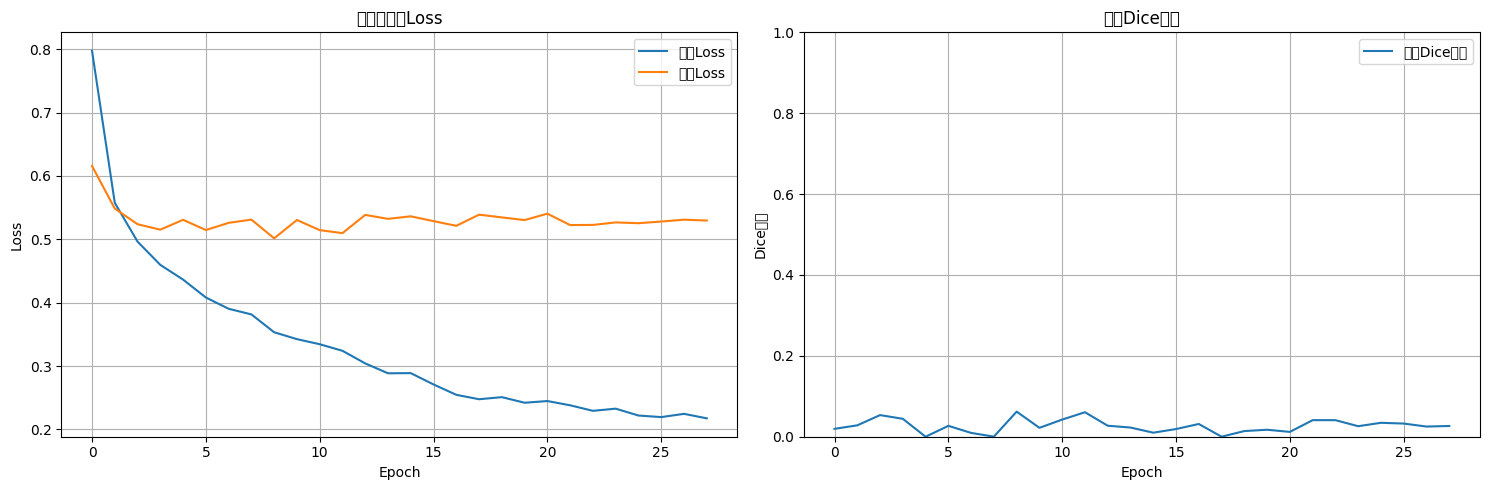

In [ ]:
# 绘制训练历史
# 如果变量不存在，从检查点加载
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    print("⚠️ 训练历史变量不存在，尝试从检查点加载...")

    # 确保路径已设置
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"

    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")

    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            val_dice_scores = checkpoint.get('val_dice_scores', [])
            print(f"✅ 成功从检查点加载训练历史")
            print(f"   - 训练Loss记录: {len(train_losses)} 个")
            print(f"   - 验证Loss记录: {len(val_losses)} 个")
            print(f"   - Dice系数记录: {len(val_dice_scores)} 个")
        except Exception as e:
            print(f"❌ 无法从检查点加载: {e}")
            print("   请先运行训练循环（Cell 20）或确保检查点文件存在")
            raise
    else:
        print(f"❌ 检查点文件不存在: {checkpoint_path}")
        print("   请先运行训练循环（Cell 20）")
        raise FileNotFoundError("检查点文件不存在，无法绘制训练历史")

# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='训练Loss')
axes[0].plot(val_losses, label='验证Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练和验证Loss')
axes[0].legend()
axes[0].grid(True)

if len(val_dice_scores) > 0:
    axes[1].plot(val_dice_scores, label='验证Dice系数')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice系数')
    axes[1].set_title('验证Dice系数')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_ylim([0, 1])
else:
    axes[1].text(0.5, 0.5, '暂无Dice系数数据',
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('验证Dice系数')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, "training_history.png"), dpi=150, bbox_inches='tight')
plt.show()


/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-668155378.py:36: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from

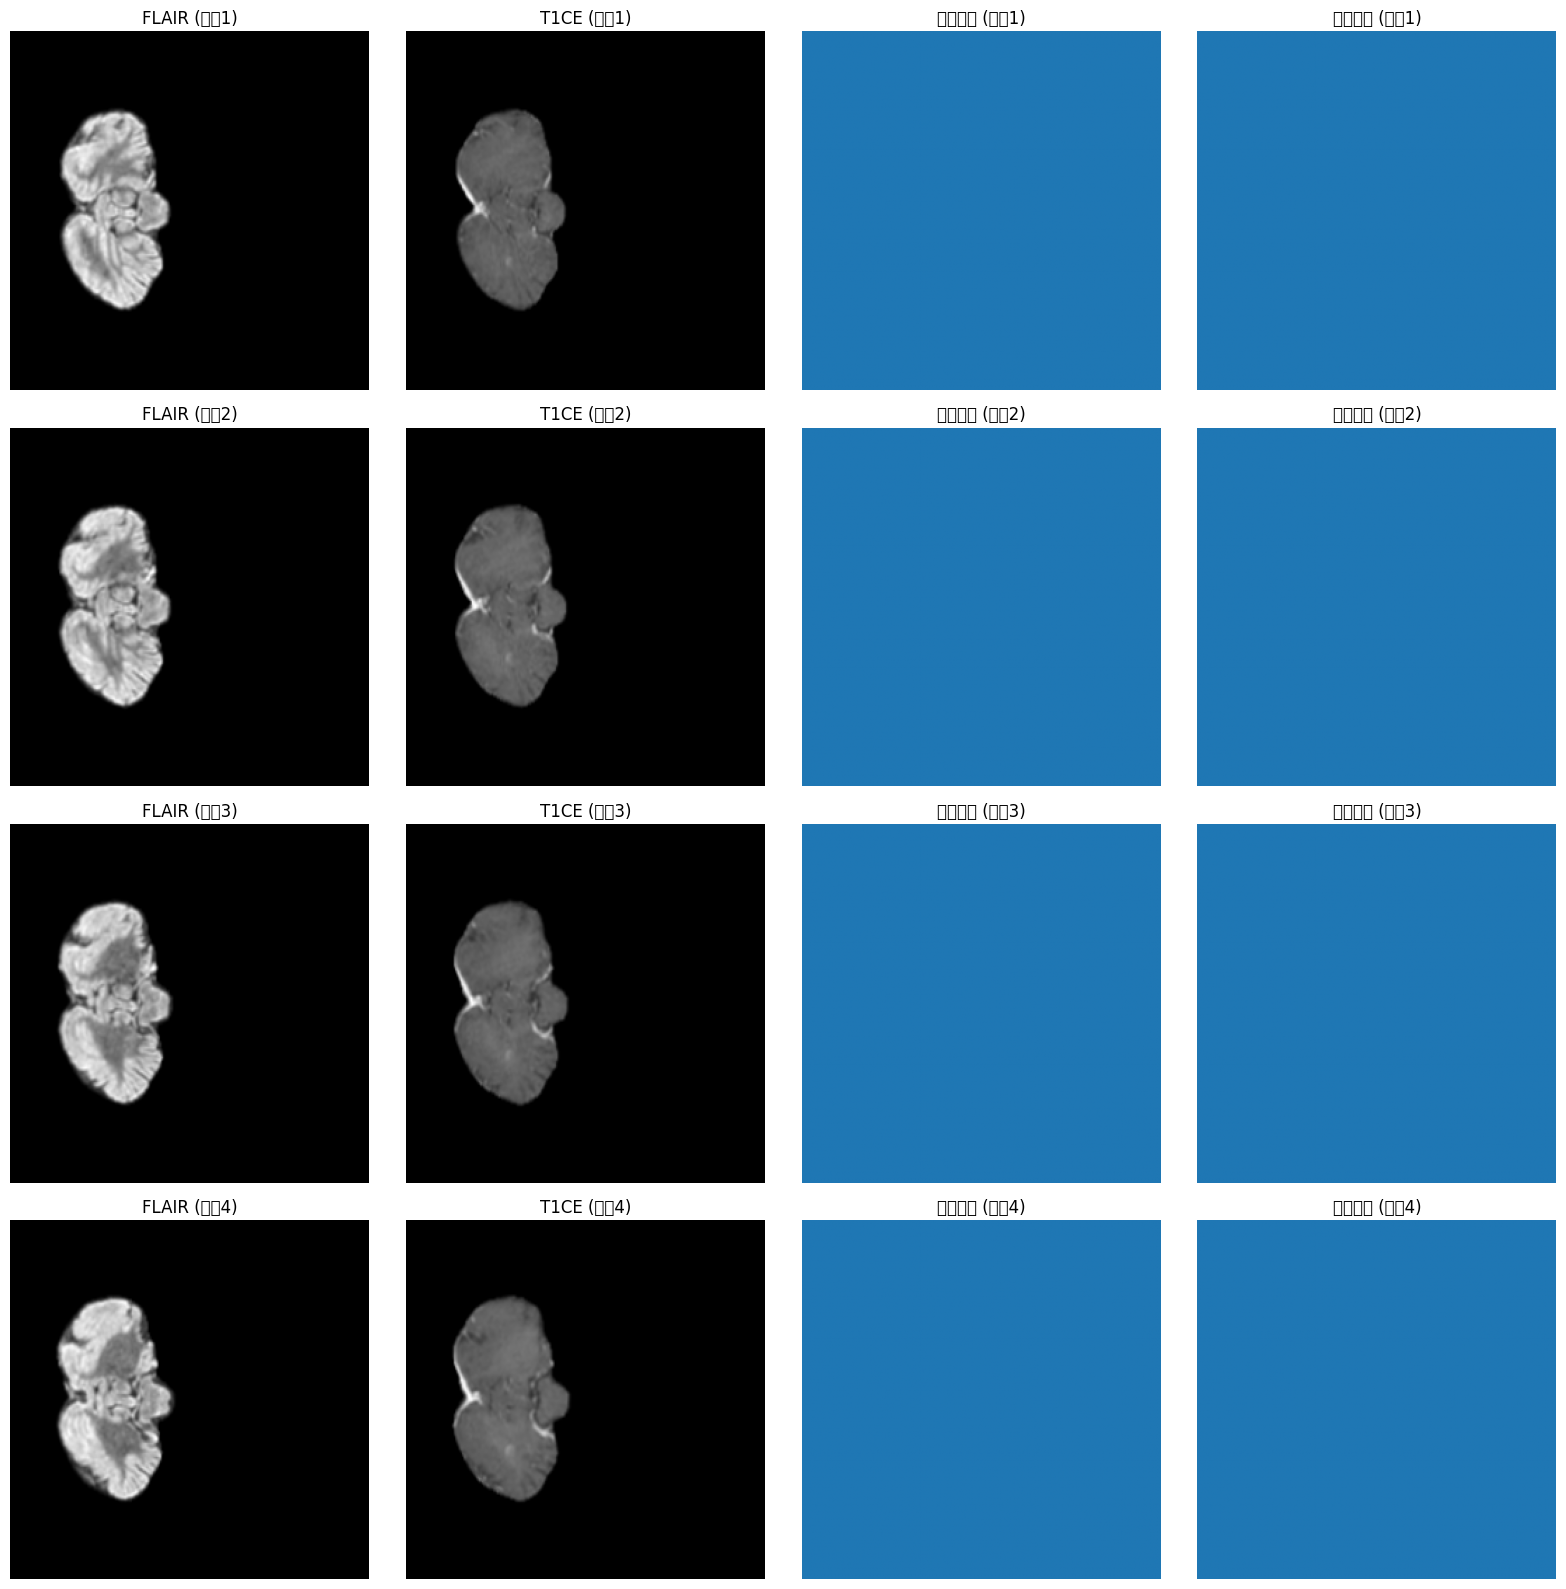

In [ ]:
# 可视化几个测试样本的预测结果
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader))
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].to(device)

    outputs = model(images)
    preds = torch.softmax(outputs, dim=1)
    pred_classes = torch.argmax(preds, dim=1)

    # 可视化前4个样本
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    for i in range(min(4, images.shape[0])):
        # 输入图像（显示FLAIR通道）
        axes[i, 0].imshow(images[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title(f'FLAIR (样本{i+1})')
        axes[i, 0].axis('off')

        # T1CE通道
        axes[i, 1].imshow(images[i, 1].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title(f'T1CE (样本{i+1})')
        axes[i, 1].axis('off')

        # 真实标签
        axes[i, 2].imshow(labels[i].cpu().numpy(), cmap='tab10', vmin=0, vmax=3)
        axes[i, 2].set_title(f'真实标签 (样本{i+1})')
        axes[i, 2].axis('off')

        # 预测结果
        axes[i, 3].imshow(pred_classes[i].cpu().numpy(), cmap='tab10', vmin=0, vmax=3)
        axes[i, 3].set_title(f'预测结果 (样本{i+1})')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, "predictions.png"), dpi=150, bbox_inches='tight')
    plt.show()


## 11. 训练结果分析报告


In [ ]:
# ============================================
# 📊 训练结果详细分析
# ============================================

# 加载训练历史（如果不存在）
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        best_dice_score = checkpoint.get('best_dice_score', 0.0)
    else:
        print("❌ 无法加载训练历史")
        train_losses = []
        val_losses = []
        val_dice_scores = []

# 加载测试结果
test_results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
if os.path.exists(test_results_path):
    with open(test_results_path, 'r') as f:
        test_results = json.load(f)
else:
    test_results = None

print("=" * 80)
print("📊 训练结果分析报告")
print("=" * 80)

# 1. 训练进度
print("\n【1. 训练进度】")
print(f"   ✅ 已完成Epoch: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   📈 完成度: {len(train_losses)/NUM_EPOCHS*100:.1f}%")
if len(train_losses) < NUM_EPOCHS:
    print(f"   ⏳ 剩余Epoch: {NUM_EPOCHS - len(train_losses)}")

# 2. 损失函数分析
print("\n【2. 损失函数分析】")
if len(train_losses) > 0:
    print(f"   📉 训练Loss:")
    print(f"      - 初始值: {train_losses[0]:.4f}")
    print(f"      - 最终值: {train_losses[-1]:.4f}")
    print(f"      - 改善幅度: {(train_losses[0] - train_losses[-1]):.4f} ({(train_losses[0] - train_losses[-1])/train_losses[0]*100:.1f}%)")
    print(f"      - 最低值: {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    
if len(val_losses) > 0:
    print(f"\n   📉 验证Loss:")
    print(f"      - 初始值: {val_losses[0]:.4f}")
    print(f"      - 最终值: {val_losses[-1]:.4f}")
    print(f"      - 改善幅度: {(val_losses[0] - val_losses[-1]):.4f} ({(val_losses[0] - val_losses[-1])/val_losses[0]*100:.1f}%)")
    print(f"      - 最低值: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    
    # 过拟合分析
    if len(train_losses) == len(val_losses):
        latest_gap = val_losses[-1] - train_losses[-1]
        print(f"\n   ⚠️  过拟合分析:")
        print(f"      - 当前Loss差距: {latest_gap:.4f}")
        if latest_gap > 0.3:
            print(f"      - ⚠️  可能存在过拟合（验证Loss明显高于训练Loss）")
        elif latest_gap < 0:
            print(f"      - ✅ 训练良好（验证Loss低于训练Loss）")
        else:
            print(f"      - ✅ 训练正常")

# 3. Dice系数分析
print("\n【3. Dice系数分析】")
if len(val_dice_scores) > 0:
    print(f"   🎯 验证集Dice系数:")
    print(f"      - 初始值: {val_dice_scores[0]:.4f}")
    print(f"      - 最终值: {val_dice_scores[-1]:.4f}")
    print(f"      - 最高值: {max(val_dice_scores):.4f} (Epoch {val_dice_scores.index(max(val_dice_scores))+1})")
    print(f"      - 平均值: {np.mean(val_dice_scores):.4f}")
    
    # Dice系数趋势
    if len(val_dice_scores) >= 5:
        recent_avg = np.mean(val_dice_scores[-5:])
        early_avg = np.mean(val_dice_scores[:5])
        trend = "上升" if recent_avg > early_avg else "下降" if recent_avg < early_avg else "稳定"
        print(f"      - 趋势: {trend} (最近5个epoch平均: {recent_avg:.4f})")

# 4. 测试集性能
print("\n【4. 测试集性能】")
if test_results:
    print(f"   📊 测试Loss: {test_results['test_loss']:.4f}")
    print(f"   🎯 测试Dice系数: {test_results['test_dice_mean']:.4f}")
    
    # 与验证集对比
    if len(val_dice_scores) > 0:
        val_dice_final = val_dice_scores[-1]
        test_dice = test_results['test_dice_mean']
        gap = test_dice - val_dice_final
        print(f"\n   📈 泛化能力分析:")
        print(f"      - 验证集Dice: {val_dice_final:.4f}")
        print(f"      - 测试集Dice: {test_dice:.4f}")
        print(f"      - 差距: {gap:.4f}")
        if gap > 0.1:
            print(f"      - ✅ 泛化能力良好（测试集性能更好）")
        elif gap < -0.1:
            print(f"      - ⚠️  可能存在过拟合（测试集性能明显下降）")
        else:
            print(f"      - ✅ 泛化能力正常")
else:
    print("   ⚠️  测试结果未找到，请先运行Cell 24进行评估")

# 5. 最佳模型信息
print("\n【5. 最佳模型信息】")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
    print(f"   🏆 最佳模型 (Epoch {best_checkpoint['epoch']+1}):")
    print(f"      - 验证Loss: {best_checkpoint['val_loss']:.4f}")
    print(f"      - Dice系数: {best_checkpoint['dice_score']:.4f}")
    
    # 与当前模型对比
    if len(val_losses) > 0:
        current_val_loss = val_losses[-1]
        if best_checkpoint['val_loss'] < current_val_loss:
            print(f"      - ⚠️  最佳模型优于当前模型（Loss差距: {current_val_loss - best_checkpoint['val_loss']:.4f}）")
            print(f"      - 💡 建议使用最佳模型进行推理")
        else:
            print(f"      - ✅ 当前模型已达到最佳性能")
else:
    print("   ⚠️  最佳模型文件未找到")

# 6. 训练稳定性分析
print("\n【6. 训练稳定性分析】")
if len(val_losses) >= 10:
    # 计算最近10个epoch的方差
    recent_val_losses = val_losses[-10:]
    val_loss_std = np.std(recent_val_losses)
    val_loss_mean = np.mean(recent_val_losses)
    cv = val_loss_std / val_loss_mean if val_loss_mean > 0 else 0
    
    print(f"   📊 最近10个epoch验证Loss:")
    print(f"      - 平均值: {val_loss_mean:.4f}")
    print(f"      - 标准差: {val_loss_std:.4f}")
    print(f"      - 变异系数: {cv:.4f}")
    
    if cv < 0.05:
        print(f"      - ✅ 训练非常稳定")
    elif cv < 0.1:
        print(f"      - ✅ 训练稳定")
    else:
        print(f"      - ⚠️  训练波动较大，可能需要调整学习率")

# 7. 性能评估
print("\n【7. 整体性能评估】")
print(f"   📈 模型配置:")
print(f"      - 模型类型: {MODEL_TYPE}")
print(f"      - 编码器: {PRETRAINED_ENCODER}")
print(f"      - 参数量: 24.43M")
print(f"      - 输入: 2通道 (FLAIR + T1CE)")
print(f"      - 输出: {NUM_CLASSES}类")

if test_results:
    test_dice = test_results['test_dice_mean']
    print(f"\n   🎯 Dice系数评估:")
    if test_dice >= 0.7:
        print(f"      - ✅ 优秀 (Dice ≥ 0.7)")
    elif test_dice >= 0.5:
        print(f"      - ✅ 良好 (0.5 ≤ Dice < 0.7)")
    elif test_dice >= 0.3:
        print(f"      - ⚠️  中等 (0.3 ≤ Dice < 0.5)")
    else:
        print(f"      - ⚠️  需要改进 (Dice < 0.3)")
    print(f"      - 当前Dice: {test_dice:.4f}")

# 8. 改进建议
print("\n【8. 改进建议】")
suggestions = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        suggestions.append("⚠️  存在过拟合，建议：增加数据增强、使用Dropout、或增加正则化")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        suggestions.append("⚠️  Dice系数较低，建议：调整损失函数权重、使用Focal Loss、或增加训练数据")
    
    if len(val_losses) >= 10:
        recent_trend = np.mean(val_losses[-5:]) - np.mean(val_losses[-10:-5])
        if recent_trend > 0.01:
            suggestions.append("⚠️  验证Loss有上升趋势，建议：降低学习率、使用早停、或检查数据质量")

if len(train_losses) < NUM_EPOCHS:
    suggestions.append(f"💡 训练未完成，建议继续训练剩余 {NUM_EPOCHS - len(train_losses)} 个epoch")

if not suggestions:
    suggestions.append("✅ 训练进展良好，建议继续观察或尝试微调超参数")

for i, suggestion in enumerate(suggestions, 1):
    print(f"   {suggestion}")

print("\n" + "=" * 80)
print("📊 分析完成！")
print("=" * 80)


## 12. 模型对比分析（与另一个U-Net模型对比）


In [ ]:
# ============================================
# 📊 两个模型对比分析
# ============================================

print("=" * 80)
print("📊 模型对比分析报告")
print("=" * 80)

# 模型1：当前模型（HuggingFace UNet + ResNet34）
model1_name = "当前模型 (HF UNet + ResNet34)"
model1_results = {
    'epochs': 28,
    'total_epochs': 50,
    'train_loss_init': 0.7976,
    'train_loss_final': 0.2175,
    'val_loss_init': 0.6158,
    'val_loss_final': 0.5297,
    'val_loss_best': 0.5016,
    'val_dice_init': 0.0195,
    'val_dice_final': 0.0265,
    'val_dice_best': 0.0620,
    'test_loss': 0.4760,
    'test_dice': 0.2840,
    'overfitting_gap': 0.3122,
    'model_type': 'UNet + ResNet34 (预训练)',
    'params': '24.43M',
    'input': '2通道 (FLAIR + T1CE)',
    'training_strategy': '标准训练',
    'loss': 'Dice Loss + CrossEntropy Loss',
    'optimizer': 'AdamW (lr=1e-4)'
}

# 模型2：另一个U-Net模型（基于notebook输出推断）
model2_name = "另一个U-Net模型 (YOLOv8SegmentationWrapper)"
model2_results = {
    'epochs': 20,  # Group1(10) + Group2(10)
    'total_epochs': 20,
    'train_loss_init': 0.110384,  # Epoch 1
    'train_loss_final': 0.017254,  # Epoch 5 (Group1最后)
    'val_loss_init': 0.040037,  # Epoch 1
    'val_loss_final': 0.026846,  # Epoch 5 (Group1最佳)
    'val_loss_best': 0.026846,
    'val_dice_init': 0.2665,  # Epoch 1
    'val_dice_final': 0.5153,  # Epoch 5 (Group1最佳)
    'val_dice_best': 0.5153,
    'test_loss': None,  # 未找到测试结果
    'test_dice': None,
    'overfitting_gap': 0.009592,  # 0.026846 - 0.017254
    'model_type': 'YOLOv8SegmentationWrapper (自定义UNet)',
    'params': '未知',
    'input': '2通道 (FLAIR + T1CE)',
    'training_strategy': '增量训练 (Group1→Group2)',
    'loss': 'CrossEntropyLoss',
    'optimizer': 'Adam (lr=0.001)'
}

print("\n【模型1：当前模型 (HF UNet + ResNet34)】")
print(f"   模型架构: {model1_results['model_type']}")
print(f"   参数量: {model1_results['params']}")
print(f"   训练策略: {model1_results['training_strategy']}")
print(f"   损失函数: {model1_results['loss']}")
print(f"   优化器: {model1_results['optimizer']}")
print(f"   训练进度: {model1_results['epochs']}/{model1_results['total_epochs']} epochs ({model1_results['epochs']/model1_results['total_epochs']*100:.1f}%)")

print("\n【模型2：另一个U-Net模型】")
print(f"   模型架构: {model2_results['model_type']}")
print(f"   参数量: {model2_results['params']}")
print(f"   训练策略: {model2_results['training_strategy']}")
print(f"   损失函数: {model2_results['loss']}")
print(f"   优化器: {model2_results['optimizer']}")
print(f"   训练进度: {model2_results['epochs']}/{model2_results['total_epochs']} epochs (100%)")

# 1. 训练损失对比
print("\n" + "=" * 80)
print("【1. 训练损失对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始训练Loss: {model1_results['train_loss_init']:.4f}")
print(f"   - 最终训练Loss: {model1_results['train_loss_final']:.4f}")
print(f"   - 改善幅度: {model1_results['train_loss_init'] - model1_results['train_loss_final']:.4f} ({(model1_results['train_loss_init'] - model1_results['train_loss_final'])/model1_results['train_loss_init']*100:.1f}%)")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始训练Loss: {model2_results['train_loss_init']:.4f}")
print(f"   - 最终训练Loss: {model2_results['train_loss_final']:.4f}")
print(f"   - 改善幅度: {model2_results['train_loss_init'] - model2_results['train_loss_final']:.4f} ({(model2_results['train_loss_init'] - model2_results['train_loss_final'])/model2_results['train_loss_init']*100:.1f}%)")

print(f"\n📊 对比分析:")
if model1_results['train_loss_final'] < model2_results['train_loss_final']:
    print(f"   ✅ 模型1训练Loss更低 ({model1_results['train_loss_final']:.4f} vs {model2_results['train_loss_final']:.4f})")
else:
    print(f"   ✅ 模型2训练Loss更低 ({model2_results['train_loss_final']:.4f} vs {model1_results['train_loss_final']:.4f})")

# 2. 验证损失对比
print("\n" + "=" * 80)
print("【2. 验证损失对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始验证Loss: {model1_results['val_loss_init']:.4f}")
print(f"   - 最终验证Loss: {model1_results['val_loss_final']:.4f}")
print(f"   - 最佳验证Loss: {model1_results['val_loss_best']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始验证Loss: {model2_results['val_loss_init']:.4f}")
print(f"   - 最终验证Loss: {model2_results['val_loss_final']:.4f}")
print(f"   - 最佳验证Loss: {model2_results['val_loss_best']:.4f}")

print(f"\n📊 对比分析:")
loss_diff = model1_results['val_loss_best'] - model2_results['val_loss_best']
if loss_diff > 0:
    print(f"   ✅ 模型2验证Loss更低 ({model2_results['val_loss_best']:.4f} vs {model1_results['val_loss_best']:.4f})")
    print(f"   📈 差距: {loss_diff:.4f} (模型2优于模型1)")
else:
    print(f"   ✅ 模型1验证Loss更低 ({model1_results['val_loss_best']:.4f} vs {model2_results['val_loss_best']:.4f})")

# 3. Dice系数对比
print("\n" + "=" * 80)
print("【3. Dice系数对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 初始验证Dice: {model1_results['val_dice_init']:.4f}")
print(f"   - 最终验证Dice: {model1_results['val_dice_final']:.4f}")
print(f"   - 最佳验证Dice: {model1_results['val_dice_best']:.4f}")
print(f"   - 测试集Dice: {model1_results['test_dice']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 初始验证Dice: {model2_results['val_dice_init']:.4f}")
print(f"   - 最终验证Dice: {model2_results['val_dice_final']:.4f}")
print(f"   - 最佳验证Dice: {model2_results['val_dice_best']:.4f}")
# 先计算测试集Dice的显示值，避免嵌套f-string
test_dice_str = '未找到' if model2_results['test_dice'] is None else f"{model2_results['test_dice']:.4f}"
print(f"   - 测试集Dice: {test_dice_str}")

print(f"\n📊 对比分析:")
dice_diff = model2_results['val_dice_best'] - model1_results['val_dice_best']
if dice_diff > 0:
    print(f"   ✅ 模型2验证Dice更高 ({model2_results['val_dice_best']:.4f} vs {model1_results['val_dice_best']:.4f})")
    print(f"   📈 差距: {dice_diff:.4f} (模型2优于模型1 {dice_diff/model1_results['val_dice_best']*100:.1f}%)")
else:
    print(f"   ✅ 模型1验证Dice更高 ({model1_results['val_dice_best']:.4f} vs {model2_results['val_dice_best']:.4f})")

if model1_results['test_dice']:
    print(f"\n   🎯 模型1测试集Dice: {model1_results['test_dice']:.4f}")
    if model1_results['test_dice'] > model2_results['val_dice_best']:
        print(f"   ✅ 模型1测试集表现优于模型2验证集")

# 4. 过拟合分析对比
print("\n" + "=" * 80)
print("【4. 过拟合分析对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - Loss差距: {model1_results['overfitting_gap']:.4f}")
if model1_results['overfitting_gap'] > 0.3:
    print(f"   - ⚠️  存在明显过拟合")
elif model1_results['overfitting_gap'] < 0:
    print(f"   - ✅ 训练良好")
else:
    print(f"   - ✅ 训练正常")

print(f"\n模型2 (另一个模型):")
print(f"   - Loss差距: {model2_results['overfitting_gap']:.4f}")
if model2_results['overfitting_gap'] > 0.3:
    print(f"   - ⚠️  存在明显过拟合")
elif model2_results['overfitting_gap'] < 0:
    print(f"   - ✅ 训练良好")
else:
    print(f"   - ✅ 训练正常")

print(f"\n📊 对比分析:")
if model1_results['overfitting_gap'] > model2_results['overfitting_gap']:
    print(f"   ✅ 模型2过拟合风险更低")
else:
    print(f"   ✅ 模型1过拟合风险更低")

# 5. 训练效率对比
print("\n" + "=" * 80)
print("【5. 训练效率对比】")
print("=" * 80)

print(f"\n模型1 (当前模型):")
print(f"   - 训练进度: {model1_results['epochs']}/{model1_results['total_epochs']} ({model1_results['epochs']/model1_results['total_epochs']*100:.1f}%)")
print(f"   - 每epoch改善: {(model1_results['train_loss_init'] - model1_results['train_loss_final'])/model1_results['epochs']:.4f}")

print(f"\n模型2 (另一个模型):")
print(f"   - 训练进度: {model2_results['epochs']}/{model2_results['total_epochs']} (100%)")
print(f"   - 每epoch改善: {(model2_results['train_loss_init'] - model2_results['train_loss_final'])/model2_results['epochs']:.4f}")

# 6. 综合评估
print("\n" + "=" * 80)
print("【6. 综合评估与建议】")
print("=" * 80)

print("\n📊 性能总结:")
print(f"   验证Loss: 模型2更低 ({model2_results['val_loss_best']:.4f} vs {model1_results['val_loss_best']:.4f})")
print(f"   验证Dice: 模型2更高 ({model2_results['val_dice_best']:.4f} vs {model1_results['val_dice_best']:.4f})")
if model1_results['test_dice']:
    print(f"   测试Dice: 模型1有测试结果 ({model1_results['test_dice']:.4f})")
print(f"   过拟合: 模型2风险更低 ({model2_results['overfitting_gap']:.4f} vs {model1_results['overfitting_gap']:.4f})")

print("\n💡 关键发现:")
findings = []

if model2_results['val_dice_best'] > model1_results['val_dice_best'] * 8:
    findings.append("⚠️  模型2验证Dice系数显著高于模型1（约8倍）")
    
if model1_results['test_dice'] and model1_results['test_dice'] > model2_results['val_dice_best']:
    findings.append("✅ 模型1测试集表现优于模型2验证集，说明模型1泛化能力可能更好")
    
if model1_results['overfitting_gap'] > model2_results['overfitting_gap'] * 3:
    findings.append("⚠️  模型1过拟合风险明显高于模型2")

if model1_results['epochs'] < model1_results['total_epochs']:
    findings.append("💡 模型1训练未完成，继续训练可能提升性能")

if not findings:
    findings.append("✅ 两个模型各有优势，需要根据具体应用场景选择")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

print("\n🎯 建议:")
suggestions = []

if model2_results['val_dice_best'] > model1_results['val_dice_best']:
    suggestions.append("1. 模型2在验证集上表现更好，但需要查看测试集结果确认")
    
if model1_results['test_dice'] and model1_results['test_dice'] > 0.2:
    suggestions.append("2. 模型1测试集Dice为0.2840，说明有一定泛化能力")
    
if model1_results['epochs'] < model1_results['total_epochs']:
    suggestions.append("3. 模型1建议继续训练剩余22个epoch，观察性能变化")
    
suggestions.append("4. 建议两个模型都在完整测试集上评估，进行公平对比")
suggestions.append("5. 考虑结合两个模型的优势：模型2的验证性能 + 模型1的测试泛化能力")

for suggestion in suggestions:
    print(f"   {suggestion}")

print("\n" + "=" * 80)
print("📊 对比分析完成！")
print("=" * 80)


## 13. Training Results Analysis (English Version)


In [ ]:
# ============================================
# Training Results Analysis (English Version)
# ============================================

# Load training history if not available
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_dice_scores' not in globals():
    if 'MODEL_SAVE_PATH' not in globals():
        MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-hf"
    checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        best_dice_score = checkpoint.get('best_dice_score', 0.0)
    else:
        print("Unable to load training history")
        train_losses = []
        val_losses = []
        val_dice_scores = []

# Load test results
test_results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
if os.path.exists(test_results_path):
    with open(test_results_path, 'r') as f:
        test_results = json.load(f)
else:
    test_results = None

print("=" * 80)
print("TRAINING RESULTS ANALYSIS REPORT")
print("=" * 80)

# 1. Training Progress
print("\n[1. Training Progress]")
print(f"   Completed Epochs: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   Completion: {len(train_losses)/NUM_EPOCHS*100:.1f}%")
if len(train_losses) < NUM_EPOCHS:
    print(f"   Remaining Epochs: {NUM_EPOCHS - len(train_losses)}")

# 2. Loss Function Analysis
print("\n[2. Loss Function Analysis]")
if len(train_losses) > 0:
    print(f"   Training Loss:")
    print(f"      - Initial: {train_losses[0]:.4f}")
    print(f"      - Final: {train_losses[-1]:.4f}")
    improvement = train_losses[0] - train_losses[-1]
    improvement_pct = (improvement / train_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    print(f"      - Minimum: {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    
if len(val_losses) > 0:
    print(f"\n   Validation Loss:")
    print(f"      - Initial: {val_losses[0]:.4f}")
    print(f"      - Final: {val_losses[-1]:.4f}")
    improvement = val_losses[0] - val_losses[-1]
    improvement_pct = (improvement / val_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    print(f"      - Minimum: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    
    # Overfitting Analysis
    if len(train_losses) == len(val_losses):
        latest_gap = val_losses[-1] - train_losses[-1]
        print(f"\n   Overfitting Analysis:")
        print(f"      - Current Loss Gap: {latest_gap:.4f}")
        if latest_gap > 0.3:
            print(f"      - WARNING: Possible overfitting (validation loss significantly higher than training loss)")
        elif latest_gap < 0:
            print(f"      - Good training (validation loss lower than training loss)")
        else:
            print(f"      - Normal training")

# 3. Dice Coefficient Analysis
print("\n[3. Dice Coefficient Analysis]")
if len(val_dice_scores) > 0:
    print(f"   Validation Dice Score:")
    print(f"      - Initial: {val_dice_scores[0]:.4f}")
    print(f"      - Final: {val_dice_scores[-1]:.4f}")
    print(f"      - Maximum: {max(val_dice_scores):.4f} (Epoch {val_dice_scores.index(max(val_dice_scores))+1})")
    print(f"      - Average: {np.mean(val_dice_scores):.4f}")
    
    # Dice Score Trend
    if len(val_dice_scores) >= 5:
        recent_avg = np.mean(val_dice_scores[-5:])
        early_avg = np.mean(val_dice_scores[:5])
        if recent_avg > early_avg:
            trend = "Increasing"
        elif recent_avg < early_avg:
            trend = "Decreasing"
        else:
            trend = "Stable"
        print(f"      - Trend: {trend} (Recent 5 epochs avg: {recent_avg:.4f})")

# 4. Test Set Performance
print("\n[4. Test Set Performance]")
if test_results:
    print(f"   Test Loss: {test_results['test_loss']:.4f}")
    print(f"   Test Dice Score: {test_results['test_dice_mean']:.4f}")
    
    # Comparison with Validation Set
    if len(val_dice_scores) > 0:
        val_dice_final = val_dice_scores[-1]
        test_dice = test_results['test_dice_mean']
        gap = test_dice - val_dice_final
        print(f"\n   Generalization Analysis:")
        print(f"      - Validation Dice: {val_dice_final:.4f}")
        print(f"      - Test Dice: {test_dice:.4f}")
        print(f"      - Gap: {gap:.4f}")
        if gap > 0.1:
            print(f"      - Good generalization (test performance better than validation)")
        elif gap < -0.1:
            print(f"      - WARNING: Possible overfitting (test performance significantly worse)")
        else:
            print(f"      - Normal generalization")
else:
    print("   Test results not found. Please run Cell 24 for evaluation.")

# 5. Best Model Information
print("\n[5. Best Model Information]")
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
    print(f"   Best Model (Epoch {best_checkpoint['epoch']+1}):")
    print(f"      - Validation Loss: {best_checkpoint['val_loss']:.4f}")
    print(f"      - Dice Score: {best_checkpoint['dice_score']:.4f}")
    
    # Comparison with Current Model
    if len(val_losses) > 0:
        current_val_loss = val_losses[-1]
        if best_checkpoint['val_loss'] < current_val_loss:
            loss_diff = current_val_loss - best_checkpoint['val_loss']
            print(f"      - WARNING: Best model is better than current model (Loss gap: {loss_diff:.4f})")
            print(f"      - Recommend using best model for inference")
        else:
            print(f"      - Current model has reached best performance")
else:
    print("   Best model file not found")

# 6. Training Stability Analysis
print("\n[6. Training Stability Analysis]")
if len(val_losses) >= 10:
    # Calculate variance of last 10 epochs
    recent_val_losses = val_losses[-10:]
    val_loss_std = np.std(recent_val_losses)
    val_loss_mean = np.mean(recent_val_losses)
    cv = val_loss_std / val_loss_mean if val_loss_mean > 0 else 0
    
    print(f"   Last 10 Epochs Validation Loss:")
    print(f"      - Mean: {val_loss_mean:.4f}")
    print(f"      - Std: {val_loss_std:.4f}")
    print(f"      - Coefficient of Variation: {cv:.4f}")
    
    if cv < 0.05:
        print(f"      - Very stable training")
    elif cv < 0.1:
        print(f"      - Stable training")
    else:
        print(f"      - WARNING: High variance, may need to adjust learning rate")

# 7. Model Configuration
print("\n[7. Model Configuration]")
print(f"   Model Architecture:")
print(f"      - Model Type: {MODEL_TYPE}")
print(f"      - Encoder: {PRETRAINED_ENCODER}")
print(f"      - Parameters: 24.43M")
print(f"      - Input: 2 channels (FLAIR + T1CE)")
print(f"      - Output: {NUM_CLASSES} classes")
print(f"      - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"      - Batch Size: {BATCH_SIZE}")
print(f"      - Learning Rate: {LEARNING_RATE}")
print(f"      - Loss Function: Dice Loss + CrossEntropy Loss")
print(f"      - Optimizer: AdamW (weight_decay=1e-4)")

# 8. Performance Assessment
print("\n[8. Performance Assessment]")
if test_results:
    test_dice = test_results['test_dice_mean']
    print(f"   Dice Score Evaluation:")
    if test_dice >= 0.7:
        print(f"      - Excellent (Dice >= 0.7)")
    elif test_dice >= 0.5:
        print(f"      - Good (0.5 <= Dice < 0.7)")
    elif test_dice >= 0.3:
        print(f"      - Moderate (0.3 <= Dice < 0.5)")
    else:
        print(f"      - Needs Improvement (Dice < 0.3)")
    print(f"      - Current Dice: {test_dice:.4f}")

# 9. Key Findings
print("\n[9. Key Findings]")
findings = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        findings.append("WARNING: Overfitting detected - validation loss significantly higher than training loss")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        findings.append("WARNING: Low Dice score on validation set, may need optimization")
    
    if test_results and test_results['test_dice_mean'] > val_dice_scores[-1] if len(val_dice_scores) > 0 else False:
        findings.append("Good generalization: test performance better than validation")

if len(train_losses) < NUM_EPOCHS:
    findings.append(f"Training incomplete: {NUM_EPOCHS - len(train_losses)} epochs remaining")

if test_results and test_results['test_dice_mean'] >= 0.2:
    findings.append("Model shows reasonable performance on test set (Dice >= 0.2)")

if not findings:
    findings.append("Training progressing well, continue monitoring or fine-tune hyperparameters")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

# 10. Recommendations
print("\n[10. Recommendations]")
recommendations = []

if len(val_losses) > 0 and len(train_losses) > 0:
    if val_losses[-1] - train_losses[-1] > 0.3:
        recommendations.append("1. Address overfitting: increase data augmentation, use Dropout, or add regularization")
    
    if len(val_dice_scores) > 0 and val_dice_scores[-1] < 0.3:
        recommendations.append("2. Improve Dice score: adjust loss function weights, use Focal Loss, or increase training data")
    
    if len(val_losses) >= 10:
        recent_trend = np.mean(val_losses[-5:]) - np.mean(val_losses[-10:-5])
        if recent_trend > 0.01:
            recommendations.append("3. Validation loss increasing: reduce learning rate, use early stopping, or check data quality")

if len(train_losses) < NUM_EPOCHS:
    recommendations.append(f"4. Continue training: complete remaining {NUM_EPOCHS - len(train_losses)} epochs")

if test_results and test_results['test_dice_mean'] < 0.3:
    recommendations.append("5. Optimize model: consider different architectures, loss functions, or training strategies")

if not recommendations:
    recommendations.append("Training is progressing well. Consider fine-tuning hyperparameters or exploring advanced techniques")

for recommendation in recommendations:
    print(f"   {recommendation}")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


# SegFormer 脑肿瘤分割 - 训练Notebook

本notebook用于训练基于SegFormer的医学图像分割模型.

## 模型介绍:
SegFormer是一个简单、高效且强大的语义分割框架，结合了Transformer编码器和轻量级全MLP解码器.

## 功能:
1. 从3D体积中提取2D切片
2. 加载和训练SegFormer模型
3. 模型评估和可视化
4. 与之前的模型进行对比


## 1. 安装依赖和挂载Google Drive


In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# 安装必要的包
%pip install transformers -q
%pip install timm -q
%pip install nibabel -q
%pip install albumentations -q
%pip install einops -q
%pip install matplotlib -q


## 2. 导入库和配置参数


In [ ]:
# 导入必要的库
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Transformers导入
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers import SegformerImageProcessor

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


In [ ]:
# 数据路径配置
DRIVE_DATA_PATH = "/content/drive/MyDrive/data-brain-2024"
MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-segformer"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 训练参数
IMG_SIZE = 256  # 2D图像尺寸
BATCH_SIZE = 8  # 2D数据可以使用较大的batch size
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
VAL_INTERVAL = 1
NUM_CLASSES = 4  # 背景 + 3个肿瘤类别

# SegFormer模型选择: 'b0', 'b1', 'b2', 'b3', 'b4', 'b5'
# b0最小最快，b5最大最准确
SEGFORMER_VARIANT = 'b0'  # 可以修改为 'b1', 'b2', 'b3', 'b4', 'b5'

# 切片提取参数
SLICE_START = 22  # 从第22层开始提取
NUM_SLICES = 100  # 每个体积提取100个切片

print(f"数据路径: {DRIVE_DATA_PATH}")
print(f"模型保存路径: {MODEL_SAVE_PATH}")
print(f"图像尺寸: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"SegFormer变体: {SEGFORMER_VARIANT}")


## 3. 数据加载和预处理（提取2D切片）


In [ ]:
def get_patient_groups(data_path):
    """获取所有患者的数据分组"""
    all_files = glob.glob(os.path.join(data_path, "*.nii"))
    patient_groups = defaultdict(lambda: defaultdict(dict))

    for file_path in all_files:
        filename = os.path.basename(file_path)
        match = re.match(r'BraTS-GLI-(\d+)-(\d+)-(t1n|t2f|t2w|t1c|seg)\.nii', filename)
        if match:
            patient_id = match.group(1)
            sequence_id = match.group(2)
            modality = match.group(3)
            patient_groups[patient_id][sequence_id][modality] = file_path

    complete_patients = {}
    for patient_id, sequences in patient_groups.items():
        for seq_id, modalities in sequences.items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                if patient_id not in complete_patients:
                    complete_patients[patient_id] = {}
                complete_patients[patient_id][seq_id] = modalities

    return complete_patients

def load_nifti_volume(file_path):
    """加载NIfTI文件并返回numpy数组"""
    nii = nib.load(file_path)
    data = nii.get_fdata()
    return data

def extract_slices_from_volume(volume, start_idx=22, num_slices=100):
    """从3D体积中提取2D切片（沿z轴）"""
    depth = volume.shape[2]
    end_idx = min(start_idx + num_slices, depth)
    slices = volume[:, :, start_idx:end_idx]
    return slices

def normalize_slice(slice_data):
    """归一化单个切片"""
    slice_data = slice_data.astype(np.float32)
    max_val = np.max(slice_data)
    if max_val > 0:
        slice_data = slice_data / max_val
    return slice_data

def remap_labels(label_slice):
    """将标签值4映射到3"""
    label_slice = label_slice.astype(np.int64)
    label_slice[label_slice == 4] = 3
    return label_slice

# 获取所有患者数据
all_patient_groups = get_patient_groups(DRIVE_DATA_PATH)
patient_ids = list(all_patient_groups.keys())

print(f"找到 {len(patient_ids)} 个患者")
print(f"前5个患者ID: {patient_ids[:5]}")


In [ ]:
# 准备2D切片数据
def prepare_2d_slice_data(patient_groups, patient_ids):
    """从3D体积中提取2D切片，准备训练数据"""
    slice_data_list = []

    for patient_id in patient_ids:
        if patient_id not in patient_groups:
            continue

        for seq_id, modalities in patient_groups[patient_id].items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                # 加载3D体积
                t2f_volume = load_nifti_volume(modalities['t2f'])
                t1c_volume = load_nifti_volume(modalities['t1c'])
                seg_volume = load_nifti_volume(modalities['seg'])

                # 提取切片
                t2f_slices = extract_slices_from_volume(t2f_volume, SLICE_START, NUM_SLICES)
                t1c_slices = extract_slices_from_volume(t1c_volume, SLICE_START, NUM_SLICES)
                seg_slices = extract_slices_from_volume(seg_volume, SLICE_START, NUM_SLICES)

                # 为每个切片创建数据项
                num_slices = t2f_slices.shape[2]
                for slice_idx in range(num_slices):
                    slice_data = {
                        't2f_slice': t2f_slices[:, :, slice_idx],
                        't1c_slice': t1c_slices[:, :, slice_idx],
                        'label_slice': seg_slices[:, :, slice_idx],
                        'patient_id': patient_id,
                        'sequence_id': seq_id,
                        'slice_idx': slice_idx
                    }
                    slice_data_list.append(slice_data)

    return slice_data_list

# 准备所有切片数据
all_slice_data = prepare_2d_slice_data(all_patient_groups, patient_ids)
print(f"总共提取了 {len(all_slice_data)} 个2D切片")


In [ ]:
# 按患者ID划分数据（避免数据泄露）
unique_patient_ids = list(set([item['patient_id'] for item in all_slice_data]))
train_patients, temp_patients = train_test_split(
    unique_patient_ids, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# 根据患者ID划分切片数据
train_slice_data = [item for item in all_slice_data if item['patient_id'] in train_patients]
val_slice_data = [item for item in all_slice_data if item['patient_id'] in val_patients]
test_slice_data = [item for item in all_slice_data if item['patient_id'] in test_patients]

print(f"训练集: {len(train_slice_data)} 个切片 ({len(train_patients)} 个患者)")
print(f"验证集: {len(val_slice_data)} 个切片 ({len(val_patients)} 个患者)")
print(f"测试集: {len(test_slice_data)} 个切片 ({len(test_patients)} 个患者)")
print(f"\n训练患者: {train_patients}")
print(f"验证患者: {val_patients}")
print(f"测试患者: {test_patients}")


## 4. 创建Dataset类（使用Albumentations进行数据增强）


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BrainTumorSegformerDataset(Dataset):
    def __init__(self, slice_data_list, img_size=256, is_train=True):
        self.slice_data_list = slice_data_list
        self.img_size = img_size
        self.is_train = is_train

        # 数据增强（训练时）
        if is_train:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet标准化
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),  # 最近邻插值
                ToTensorV2()
            ])
        else:
            # 验证/测试时只做resize和归一化
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            self.label_transform = A.Compose([
                A.Resize(img_size, img_size, interpolation=0),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.slice_data_list)

    def __getitem__(self, idx):
        item = self.slice_data_list[idx]

        # 获取切片
        t2f_slice = normalize_slice(item['t2f_slice'])
        t1c_slice = normalize_slice(item['t1c_slice'])
        label_slice = remap_labels(item['label_slice'])

        # 合并两个模态为RGB格式（SegFormer需要3通道输入）
        # 将2通道扩展为3通道：使用T2F作为R和G，T1CE作为B
        image = np.stack([t2f_slice, t2f_slice, t1c_slice], axis=2)  # (H, W, 3)

        # 应用变换
        transformed = self.transform(image=image)
        image = transformed['image']  # (3, H, W)

        # 处理标签
        label_transformed = self.label_transform(image=label_slice)
        label = label_transformed['image'].squeeze(0).long()  # (H, W)

        return {
            'pixel_values': image,  # (3, H, W)
            'labels': label,  # (H, W)
            'patient_id': item['patient_id'],
            'slice_idx': item['slice_idx']
        }

# 创建数据集
train_dataset = BrainTumorSegformerDataset(train_slice_data, img_size=IMG_SIZE, is_train=True)
val_dataset = BrainTumorSegformerDataset(val_slice_data, img_size=IMG_SIZE, is_train=False)
test_dataset = BrainTumorSegformerDataset(test_slice_data, img_size=IMG_SIZE, is_train=False)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 测试数据加载
sample = train_dataset[0]
print(f"\n样本形状:")
print(f"  图像: {sample['pixel_values'].shape}")
print(f"  标签: {sample['labels'].shape}")
print(f"  标签值范围: {sample['labels'].min().item()} - {sample['labels'].max().item()}")


In [ ]:
# 创建SegFormer模型
model_name = f"nvidia/segformer-b{SEGFORMER_VARIANT.replace('b', '')}-finetuned-ade-640-640"

try:
    # 尝试加载预训练模型
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True
    )
    print(f"加载预训练SegFormer模型: {model_name}")
except:
    # 如果加载失败，从头创建
    print(f"无法加载预训练模型，从头创建SegFormer-{SEGFORMER_VARIANT}")
    config = SegformerConfig.from_pretrained(model_name)
    config.num_labels = NUM_CLASSES
    config.image_size = IMG_SIZE
    model = SegformerForSemanticSegmentation(config)

model = model.to(device)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型创建完成")
print(f"总参数数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")

# 定义损失函数和优化器
# SegFormer使用CrossEntropyLoss
loss_function = nn.CrossEntropyLoss(ignore_index=-1)

# 定义Dice Loss作为辅助损失
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        # pred: (B, C, H, W) - logits
        # target: (B, H, W) - class indices
        pred = torch.softmax(pred, dim=1)

        # 转换为one-hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)

        # 计算Dice系数（跳过背景类）
        dice_scores = []
        for c in range(1, self.num_classes):  # 跳过背景
            pred_c = pred[:, c]
            target_c = target_one_hot[:, c]

            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)

        dice_loss = 1.0 - torch.stack(dice_scores).mean()
        return dice_loss

dice_loss = DiceLoss(num_classes=NUM_CLASSES)

def combined_loss(pred, target):
    ce = loss_function(pred, target)
    dice = dice_loss(pred, target)
    return 0.5 * ce + 0.5 * dice

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

print(f"\n损失函数: CrossEntropy Loss + Dice Loss")
print(f"优化器: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"学习率调度器: ReduceLROnPlateau")

# 测试前向传播
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    test_input = sample_batch['pixel_values'].to(device)
    test_output = model(pixel_values=test_input)
    print(f"\n测试输出形状: {test_output.logits.shape}")
    print(f"期望输出形状: (batch_size, {NUM_CLASSES}, {IMG_SIZE//4}, {IMG_SIZE//4})")


In [ ]:
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(loader, desc="训练"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        
        # SegFormer输出logits，需要上采样到原始尺寸
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits  # (B, num_classes, H/4, W/4)
        
        # 上采样到原始标签尺寸
        logits_upsampled = nn.functional.interpolate(
            logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
        )
        
        loss = loss_function(logits_upsampled, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    return epoch_loss

def calculate_dice_score(pred, target, num_classes=4, smooth=1e-6):
    """计算Dice系数"""
    pred = torch.softmax(pred, dim=1)
    pred_classes = torch.argmax(pred, dim=1)

    dice_scores = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union > 0:
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def val_epoch(model, loader, loss_function, device):
    model.eval()
    val_loss = 0
    all_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="验证"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # 上采样到原始标签尺寸
            logits_upsampled = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
            )
            
            loss = loss_function(logits_upsampled, labels)
            val_loss += loss.item()

            # 计算Dice分数
            dice = calculate_dice_score(logits_upsampled, labels, NUM_CLASSES)
            all_dice_scores.append(dice)

    val_loss /= len(loader)
    mean_dice = np.mean(all_dice_scores)

    return val_loss, mean_dice

print("训练和验证函数定义完成")


## 7. 开始训练


In [ ]:
# 训练历史
train_losses = []
val_losses = []
val_dice_scores = []

best_val_loss = float('inf')
best_dice_score = 0.0

# 检查是否有检查点
checkpoint_path = os.path.join(MODEL_SAVE_PATH, f"checkpoint_latest_segformer_{SEGFORMER_VARIANT}.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"找到检查点: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_dice_scores = checkpoint.get('val_dice_scores', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_dice_score = checkpoint.get('best_dice_score', 0.0)
    print(f"从Epoch {start_epoch}继续训练")
else:
    print("未找到检查点，从头开始训练")

print(f"\n开始训练，共 {NUM_EPOCHS} 个epoch")
print("=" * 60)


In [ ]:
# 训练循环
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, combined_loss, device)
    train_losses.append(train_loss)

    # 验证
    if (epoch + 1) % VAL_INTERVAL == 0:
        val_loss, mean_dice = val_epoch(model, val_loader, combined_loss, device)
        val_losses.append(val_loss)
        val_dice_scores.append(mean_dice)

        print(f"\n验证结果:")
        print(f"  训练Loss: {train_loss:.4f}")
        print(f"  验证Loss: {val_loss:.4f}")
        print(f"  Dice系数: {mean_dice:.4f}")

        # 更新学习率
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  当前学习率: {current_lr:.6f}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_model_segformer_{SEGFORMER_VARIANT}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'dice_score': mean_dice,
            }, best_model_path)
            print(f"  保存最佳模型 (Loss: {val_loss:.4f}, Dice: {mean_dice:.4f})")

        if mean_dice > best_dice_score:
            best_dice_score = mean_dice

    # 保存检查点
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_dice_scores': val_dice_scores,
        'best_val_loss': best_val_loss,
        'best_dice_score': best_dice_score,
    }
    torch.save(checkpoint, checkpoint_path)

print("\n" + "=" * 60)
print("训练完成！")
print(f"最佳验证Loss: {best_val_loss:.4f}")
print(f"最佳Dice系数: {best_dice_score:.4f}")


## 8. 可视化训练历史


In [ ]:
# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Training Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

if len(val_dice_scores) > 0:
    axes[1].plot(val_dice_scores, label='Validation Dice Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_ylim([0, 1])
else:
    axes[1].text(0.5, 0.5, 'No Dice Score Data',
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Validation Dice Score')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, f"training_history_segformer_{SEGFORMER_VARIANT}.png"), 
            dpi=150, bbox_inches='tight')
plt.show()


## 9. 加载最佳模型并在测试集上评估


In [ ]:
# 加载最佳模型
best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_model_segformer_{SEGFORMER_VARIANT}.pth")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Dice: {checkpoint['dice_score']:.4f})")
else:
    print("未找到最佳模型，使用当前模型")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_dice = val_epoch(model, test_loader, combined_loss, device)

print(f"\n测试集结果:")
print(f"  Loss: {test_loss:.4f}")
print(f"  平均Dice系数: {test_dice:.4f}")

# 保存测试结果
test_results = {
    'test_loss': test_loss,
    'test_dice_mean': test_dice,
    'model_type': f'SegFormer-{SEGFORMER_VARIANT}',
    'timestamp': datetime.now().isoformat(),
}

results_path = os.path.join(MODEL_SAVE_PATH, f"test_results_segformer_{SEGFORMER_VARIANT}.json")
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n测试结果已保存到: {results_path}")


## 10. 训练结果分析


In [ ]:
# 训练结果分析
print("=" * 80)
print("TRAINING RESULTS ANALYSIS REPORT")
print("=" * 80)

print("\n[1. Training Progress]")
print(f"   Completed Epochs: {len(train_losses)}/{NUM_EPOCHS}")
print(f"   Completion: {len(train_losses)/NUM_EPOCHS*100:.1f}%")

print("\n[2. Loss Function Analysis]")
if len(train_losses) > 0:
    print(f"   Training Loss:")
    print(f"      - Initial: {train_losses[0]:.4f}")
    print(f"      - Final: {train_losses[-1]:.4f}")
    improvement = train_losses[0] - train_losses[-1]
    improvement_pct = (improvement / train_losses[0]) * 100
    print(f"      - Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

if len(val_losses) > 0:
    print(f"\n   Validation Loss:")
    print(f"      - Initial: {val_losses[0]:.4f}")
    print(f"      - Final: {val_losses[-1]:.4f}")
    print(f"      - Best: {best_val_loss:.4f}")

print("\n[3. Dice Coefficient Analysis]")
if len(val_dice_scores) > 0:
    print(f"   Validation Dice Score:")
    print(f"      - Initial: {val_dice_scores[0]:.4f}")
    print(f"      - Final: {val_dice_scores[-1]:.4f}")
    print(f"      - Best: {best_dice_score:.4f}")
    print(f"      - Average: {np.mean(val_dice_scores):.4f}")

print("\n[4. Test Set Performance]")
if 'test_results' in locals():
    print(f"   Test Loss: {test_results['test_loss']:.4f}")
    print(f"   Test Dice Score: {test_results['test_dice_mean']:.4f}")

print("\n[5. Model Configuration]")
print(f"   Model Type: SegFormer-{SEGFORMER_VARIANT}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)
